In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import pygsp
import mplleaflet
import scipy as sp

from sklearn.cluster import KMeans

from utils.indexes import days_index, hour_rides, transform_source

In [2]:
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
from networkx.algorithms.community.quality import performance, coverage
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community.asyn_fluid import asyn_fluidc


March 1st: first reported case in New York 
<br>
March 4th: Yeshiva University campus closed, high school in the Bronx 
<br>
March 9th 16 confirmed cases 
<br>
March 10th: mitigation measures expanded (online classes for universities) 
<br>
March 11th: CUNY and SUNY closed
<br>
March 14th: first reported death in New York 
<br>
March 16th: NYC public schools closed 
<br>
March 20th: stay-at-home order for non-essential workers, total over 7000 cases
<br>
March 22nd: shortages of PPE for health workers, recommendation that health facilities stop testing non-hospitalized patients
<br>
March 26th: USNS Comfort heading to NYC to assist local hospitals 


New York Weather : MARCH

[weather data](https://www.timeanddate.com/weather/usa/new-york/historic?month=3&year=2020)

In [3]:
df = pd.read_csv('./data/202003-citibike-tripdata.csv')
n_start_station = len(df['start station id'].unique())
n_end_station = len(df['end station id'].unique())


total_station_id = set(df['start station id']).union(set(df['end station id']))
n_tot_station = len(total_station_id)

id_index = dict(zip(sorted(total_station_id), np.arange(n_tot_station)))

# Find Locations #

In [4]:
locations = dict()
for e in id_index.keys():
    if df[df['start station id'] == e]['start station latitude'].shape[0]:
        locations[id_index[e]] = (df[df['start station id'] == e]['start station longitude'].iloc[0],
                                  df[df['start station id'] == e]['start station latitude'].iloc[0])
    else:
        locations[id_index[e]] = (df[df['end station id'] == e]['end station longitude'].iloc[0],
                                  df[df['end station id'] == e]['end station latitude'].iloc[0])
 

# MARCH #

In [5]:
# Dictionary with days starting indexes
"""d = days_index(df)
with open('./data/variables/march_index.pickle', 'wb') as file:
    pickle.dump(d, file)"""


"d = days_index(df)\nwith open('./data/variables/march_index.pickle', 'wb') as file:\n    pickle.dump(d, file)"

In [6]:
# Load day indexes for March
with open('./data/python_variables/march_index.pickle', 'rb') as file:
    d = pickle.load(file)

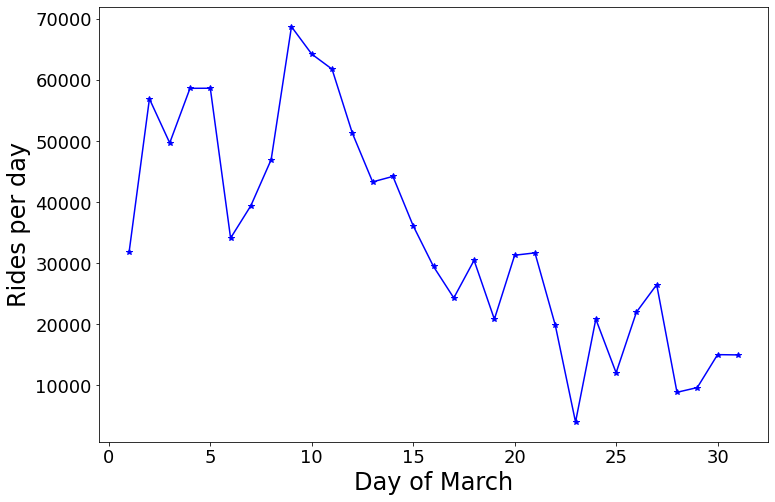

In [7]:
d_a = [e for e in d.values()]
d_a.append(df.shape[0])
d_a = np.array(d_a)
rides_day = d_a[1:] - d_a[:-1]

# Rides Per Day
plt.figure(figsize=(12,8))
_ = plt.plot(np.arange(1, 32), rides_day, color='blue', marker='*')
# _ = plt.xticks(np.arange(1, 8), [1, 5, 10, 15, 20, 25, 31], fontsize=18)
_ = plt.xlabel("Day of March", fontsize=24, color='black')
_ = plt.ylabel("Rides per day", fontsize=24, color='black')
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.grid(False)
plt.savefig('./plots/days_aggregated.eps')

In [8]:
print("Maximum number of rides on day {}".format(np.argmax(rides_day)))
print("With {} rides".format(np.max(rides_day)))

Maximum number of rides on day 8
With 68768 rides


In [9]:
# Paramters 
ths = 1

In [10]:
out_nodes = []
for k, v in locations.items():
    if v[0] < -74.02:
        out_nodes.append(k)
out_nodes = set(out_nodes)

## 2st-6th of March ##

In [11]:
# 2 -> Monday
# Choose day 
days = [2, 3, 4, 5, 6]


# Find all connections with weights
adj_2_6_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        
        adj_2_6_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_2_6_tot[id_index[row['end station id']], id_index[row['start station id']]] +=1
    print('Day {} loaded...'.format(day))
    

Day 2 loaded...
Day 3 loaded...
Day 4 loaded...
Day 5 loaded...
Day 6 loaded...


In [12]:
print("Total number of rides : {}".format(np.sum(adj_2_6_tot) / 2))

Total number of rides : 258160.0


In [13]:
adj_2_6 = adj_2_6_tot.copy()
adj_2_6[adj_2_6 <= ths] = 0
# adj_2_6[adj_2_6 >= ths] = 1
print("Unweighted number of rides (edges) : {}".format(np.sum(adj_2_6) / 2))

for i in range(n_tot_station):
    adj_2_6[i, i] = 0

Unweighted number of rides (edges) : 234391.0


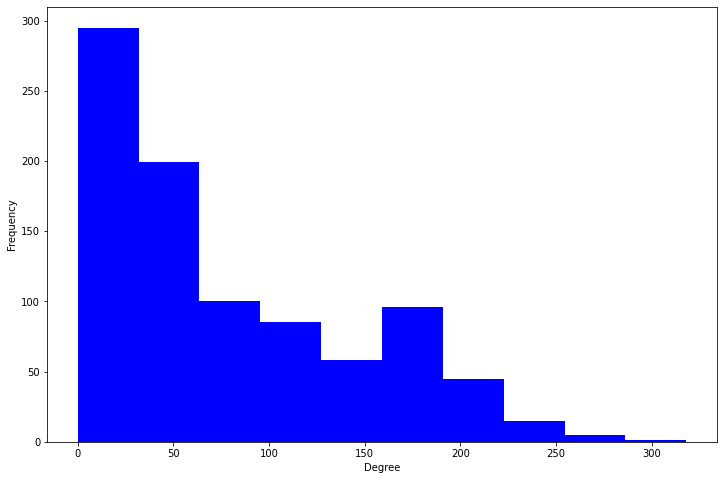

In [14]:
# Create Undirected graph 
plt.figure(figsize=(12,8))
g_2_6 = nx.from_numpy_matrix(adj_2_6)
g_2_6_tot = nx.from_numpy_matrix(adj_2_6)
plt.xlabel('Degree')
plt.ylabel("Frequency")
plt.grid(False)
degs_2_6 = np.array([x[1] for x in g_2_6.degree])
_ = plt.hist(degs_2_6, color='blue')
plt.savefig('./plots/degree_2_6.eps')

In [15]:
sp.stats.entropy(np.histogram(degs_2_6, bins=12)[0])

2.013126588901429

### Clustering ###

In [16]:
isolated_nodes_2_6 = []
for e in nx.connected_components(g_2_6):
    if len(e) < 3:
        isolated_nodes_2_6.append(e.pop())

isolated_nodes_2_6.extend(out_nodes)
isolated_nodes_2_6 = list(set(isolated_nodes_2_6))
g_2_6.remove_nodes_from(isolated_nodes_2_6)

for e in nx.connected_components(g_2_6):
    if len(e) < 3:
        print(e)

In [17]:
G_2_6 = pygsp.graphs.Graph(nx.adjacency_matrix(g_2_6))

G_2_6.compute_laplacian()
G_2_6.compute_fourier_basis()

In [18]:
print("ACC: {}".format(nx.algorithms.cluster.average_clustering(g_2_6)))

ACC: 0.41782168112512963


In [19]:
k = 4
c_g = list(asyn_fluidc(g_2_6, 4))


In [20]:
cols = {}
for i in range(len(c_g)):
    for node in c_g[i]:
        cols[node] = i

l_c = [cols[e] for e in sorted(list(cols.keys()))]

In [21]:
def weighted_covergae(g, p):
    d_i = dict(zip(np.arange(g.number_of_nodes()), list(g.nodes())))
    n = g.number_of_nodes()
    ad = nx.adjacency_matrix(g)
    p_sum = np.sum(ad) / 2
    num = 0
    for i in range(n):
        for j in range(i+1, n):
            if p[d_i[i]] == p[d_i[j]]:
                num += ad[i,j]
                
    return num / p_sum
    

In [198]:
def compute_flows(g, s):
    inner = 0
    outer = 0
    d_i = dict(zip(list(g.nodes()), np.arange(g.number_of_nodes())))
    n = g.number_of_nodes()
    ad = nx.adjacency_matrix(g)
    s = set(s)
    for e in s:
        if d_i.get(e) is not None:
            for n in nx.neighbors(g, e):
                if n in s:
                    inner += ad[d_i[e], d_i[n]]
                else:
                    outer += ad[d_i[e], d_i[n]]
                
    return inner, outer

def compute_flows_between(g, s, t):
    flow = 0
    d_i = dict(zip(list(g.nodes()), np.arange(g.number_of_nodes())))
    n = g.number_of_nodes()
    ad = nx.adjacency_matrix(g)
    for e in s:
        for n in t:
            if d_i.get(e) is not None and d_i.get(n) is not None:
                flow += ad[d_i[e], d_i[n]]
                
    return flow


In [23]:
import community 

max_mod_2_6 = 0
part_2_6 = None

for i in range(20):

    partition = community.best_partition(g_2_6, weight='weight')
    c_g = [set() for e in range(len(partition))]
    for k, v in partition.items():
        c_g[v].add(k)
    mod = community.modularity(partition, g_2_6, weight='weight')
    if max_mod_2_6 < mod:
        max_mod_2_6 = mod
        part_2_6 = partition


In [24]:
print("weighted coverage : {}".format(weighted_covergae(g_2_6, part_2_6)))

weighted coverage : 0.7126401913709719


In [25]:
import matplotlib

In [26]:
color_cluster = ['yellow', 'blue', 'red', 'gray', 'green']
vec_col_2_6 = [color_cluster[e] for e in part_2_6.values()]

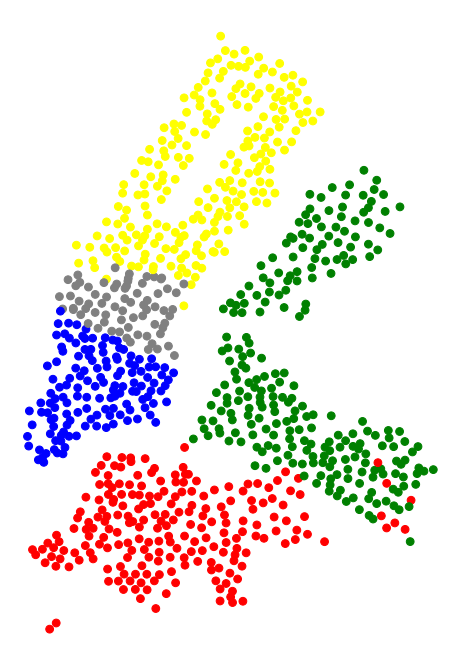

In [27]:
plt.figure(figsize=(8,12))

nx.draw_networkx_nodes(g_2_6, locations, node_size=60, node_color=vec_col_2_6)
# nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black')

plt.grid(False)
_ = plt.axis('off')

In [28]:
color_cluster

['yellow', 'blue', 'red', 'gray', 'green']

In [ ]:
compute_flows_between(g_23_27, p_23_27[0], p_23_27[1])

## 9th-13th of March ##

In [30]:
ov = 0
ov2 = 0
for k,v in locations.items():
    if v[0] < locations[ov][0]:
        ov2 = ov
        ov = k     
    elif v[0] < locations[ov2][0]:
        ov2 = k

In [31]:
# 9 -> Monday
# Choose day 
days = [9, 10, 11, 12, 13]

# Find all connections with weights
adj_9_13_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_9_13_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_9_13_tot[id_index[row['end station id']], id_index[row['start station id']]] += 1
    print('Day {} loaded...'.format(day))
    

Day 9 loaded...
Day 10 loaded...
Day 11 loaded...
Day 12 loaded...
Day 13 loaded...


In [32]:
print("Total number of rides : {}".format(np.sum(adj_9_13_tot) / 2))

Total number of rides : 289536.0


In [33]:
adj_9_13 = adj_9_13_tot.copy()
adj_9_13[adj_9_13 <= ths] = 0
# adj_9_13[adj_9_13 >= ths] = 1

print("Unweighted number of rides : {}".format(np.sum(adj_9_13) / 2))

# Remove Self-loops
for i in range(n_tot_station):
    adj_9_13[i, i] = 0

Unweighted number of rides : 260814.0


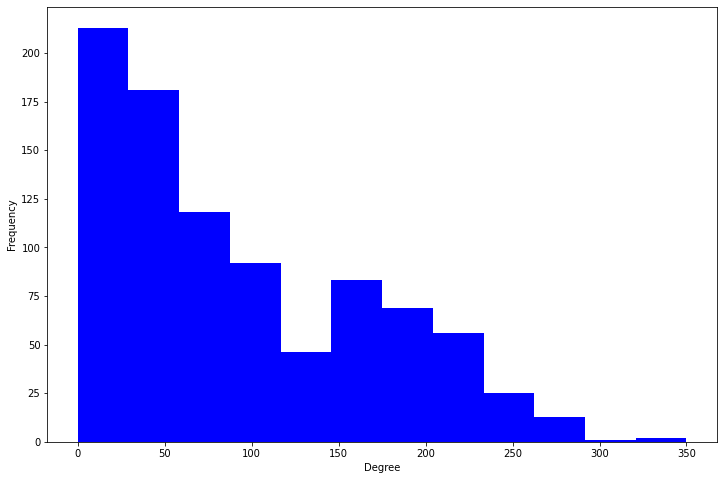

In [34]:
# Create Undirected graph 
plt.figure(figsize=(12,8))
g_9_13 = nx.from_numpy_matrix(adj_9_13)
g_9_13_tot = nx.from_numpy_matrix(adj_9_13)
plt.xlabel('Degree')
plt.ylabel("Frequency")
plt.grid(False)
degs_9_13 = np.array([x[1] for x in g_9_13.degree])
_ = plt.hist(degs_9_13, bins=12, color='blue')
plt.savefig('./plots/degree_9_13.eps')

In [35]:
sp.stats.entropy(np.histogram(degs_9_13, bins=12)[0])

2.0877286645667237

In [36]:
print(nx.average_clustering(g_9_13))

0.4238727831833754


## Plot Clusters ##

In [37]:
isolated_nodes_9_13 = []
for e in nx.connected_components(g_9_13):
    if len(e) < 3:
        isolated_nodes_9_13.append(e.pop())

isolated_nodes_9_13.extend(out_nodes)
isolated_nodes_9_13 = list(set(isolated_nodes_9_13))
g_9_13.remove_nodes_from(isolated_nodes_9_13)

for e in nx.connected_components(g_9_13):
    if len(e) < 3:
        print(e)

In [38]:
G_9_13 = pygsp.graphs.Graph(nx.adjacency_matrix(g_9_13))

G_9_13.compute_laplacian()
G_9_13.compute_fourier_basis()

In [39]:
import community 

max_mod_9_13 = 0
part_9_13 = None

for i in range(20):

    partition = community.best_partition(g_9_13, weight='weight')
    c_g = [set() for e in range(len(partition))]
    for k, v in partition.items():
        c_g[v].add(k)
    mod = community.modularity(partition, g_9_13, weight='weight')
    if max_mod_9_13 < mod:
        max_mod_9_13 = mod
        part_9_13 = partition


In [40]:
print("weighted coverage : {}".format(weighted_covergae(g_9_13, part_9_13)))


weighted coverage : 0.6831583444048612


In [41]:
color_cluster = ['yellow', 'blue', 'red', 'gray', 'green']
vec_col_9_13 = [color_cluster[e] for e in part_9_13.values()]

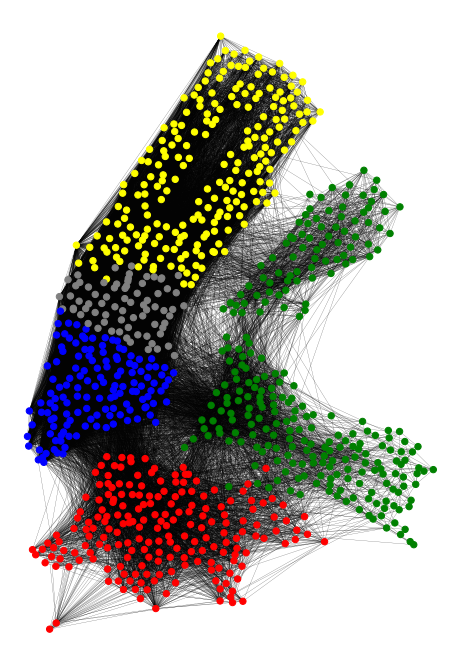

In [42]:
plt.figure(figsize=(8, 12))

nx.draw_networkx_nodes(g_9_13, locations, node_size=40, node_color=vec_col_9_13)
nx.draw_networkx_edges(g_9_13, locations, alpha=0.8, width=0.2, edge_color='black')

plt.grid(False)
_ = plt.axis('off')

#plt.savefig('plots/cluster_5_9_trade.jpeg')

#mplleaflet.show()

## 16th-20th of March ##

In [43]:
# 16 -> Monday
# Choose day 
days = [16, 17, 18, 19, 20]

# Find all connections with weights
adj_16_20_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_16_20_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_16_20_tot[id_index[row['end station id']], id_index[row['start station id']]] += 1
    print('Day {} loaded...'.format(day))
    

Day 16 loaded...
Day 17 loaded...
Day 18 loaded...
Day 19 loaded...
Day 20 loaded...


In [44]:
print("Total number of rides : {}".format(np.sum(adj_16_20_tot) / 2))

Total number of rides : 136477.0


In [45]:
adj_16_20 = adj_16_20_tot.copy()
adj_16_20[adj_16_20 <= ths] = 0
"""adj_16_20[adj_16_20 >= ths] = 1"""

print("Unweighted number of rides : {}".format(np.sum(adj_16_20) / 2))

# Remove Self-loops
for i in range(n_tot_station):
    adj_16_20[i, i] = 0

Unweighted number of rides : 113508.0


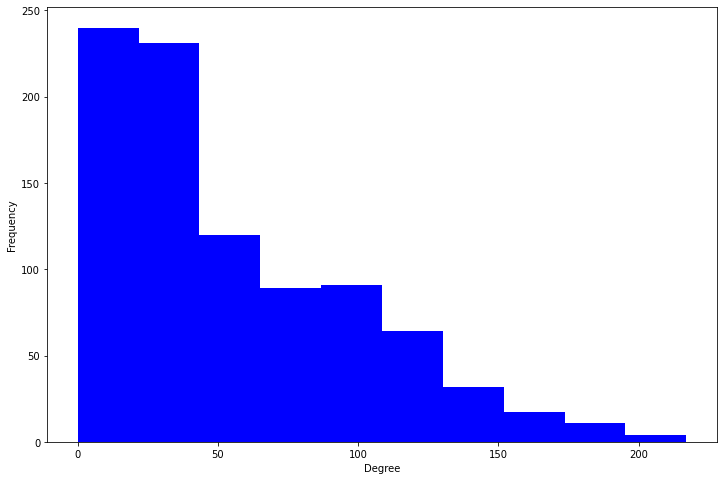

In [46]:
# Create Undirected graph 
plt.figure(figsize=(12,8))
g_16_20 = nx.from_numpy_matrix(adj_16_20)
g_16_20_tot = nx.from_numpy_matrix(adj_16_20)
plt.xlabel('Degree')
plt.ylabel("Frequency")
plt.grid(False)
degs_16_20 = np.array([x[1] for x in g_16_20.degree])
_ = plt.hist(degs_16_20, color='blue')
plt.savefig('./plots/degree_16_20.eps')

## Plot Clusters ## 

In [47]:
isolated_nodes_16_20 = []
for e in nx.connected_components(g_16_20):
    if len(e) < 3:
        isolated_nodes_16_20.append(e.pop())
isolated_nodes_16_20.extend(out_nodes)
isolated_nodes_16_20 = list(set(isolated_nodes_16_20))
g_16_20.remove_nodes_from(isolated_nodes_16_20)

for e in nx.connected_components(g_16_20):
    if len(e) < 3:
        print(e)

In [48]:
isolated_nodes_16_20_ = []
for e in nx.connected_components(g_16_20):
    if len(e) < 3:
        isolated_nodes_16_20_.append(e.pop())
isolated_nodes_16_20 = list(set(isolated_nodes_16_20))
g_16_20.remove_nodes_from(isolated_nodes_16_20_)

In [49]:
for e in nx.connected_components(g_16_20):
    if len(e) < 3:
        print(e)

In [50]:
isolated_nodes_16_20.extend(isolated_nodes_16_20_)
isolated_nodes_16_20 = list(set(isolated_nodes_16_20))

In [51]:
G_16_20 = pygsp.graphs.Graph(nx.adjacency_matrix(g_16_20))

G_16_20.compute_laplacian()
G_16_20.compute_fourier_basis()

In [52]:
nx.algorithms.cluster.average_clustering(g_16_20)

0.3106690590812846

In [53]:
sp.stats.entropy(np.histogram(degs_16_20, bins=12)[0])

2.071667170595518

In [54]:
import community 

max_mod_16_20 = 0
part_16_20 = None

for i in range(20):

    partition = community.best_partition(g_16_20, weight='weight')
    c_g = [set() for e in range(len(partition))]
    for k, v in partition.items():
        c_g[v].add(k)
    mod = community.modularity(partition, g_16_20, weight='weight')
    if max_mod_16_20 < mod:
        max_mod_16_20 = mod
        part_16_20 = partition


In [55]:
print("weighted coverage : {}".format(weighted_covergae(g_16_20, part_16_20)))

weighted coverage : 0.7182639426983917


In [56]:
color_cluster = ['yellow', 'blue', 'red', 'gray', 'green']
vec_col_16_20 = [color_cluster[e] for e in part_16_20.values()]

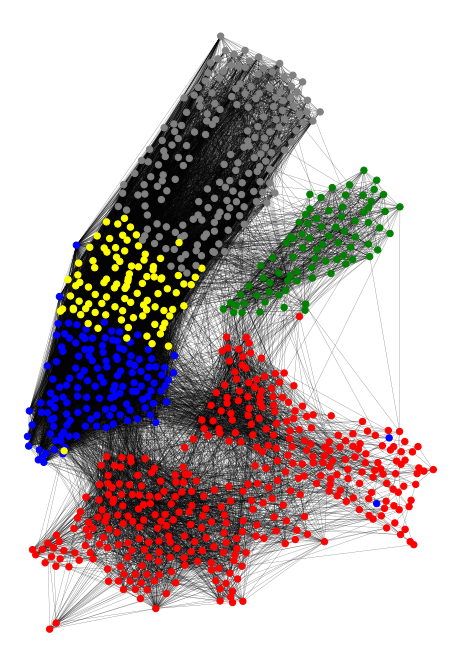

In [57]:
plt.figure(figsize=(8, 12))

nx.draw_networkx_nodes(g_16_20, locations, node_size=40, node_color=vec_col_16_20)
nx.draw_networkx_edges(g_16_20, locations, alpha=0.8, width=0.2, edge_color='black')

plt.grid(False)
_ = plt.axis('off')

plt.savefig('plots/weighted_cluster_16_20.jpeg')

#mplleaflet.show()

## 23st-27th of March ##

In [58]:
# 23 -> Monday
# Choose day 
days = [23, 24, 25, 26, 27]


# Find all connections with weights
adj_23_27_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_23_27_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_23_27_tot[id_index[row['end station id']], id_index[row['start station id']]] += 1
    print('Day {} loaded...'.format(day))
    

Day 23 loaded...
Day 24 loaded...
Day 25 loaded...
Day 26 loaded...
Day 27 loaded...


In [59]:
print("Total number of rides : {}".format(np.sum(adj_23_27_tot) / 2))

Total number of rides : 85428.0


In [60]:
adj_23_27 = adj_23_27_tot.copy()
adj_23_27[adj_23_27 <= ths] = 0
"""adj_23_27[adj_23_27 >= ths] = 1"""
print("Unweighted number of rides : {}".format(np.sum(adj_23_27) / 2))

# Remove Self-loops
for i in range(n_tot_station):
    adj_23_27[i, i] = 0

Unweighted number of rides : 67368.0


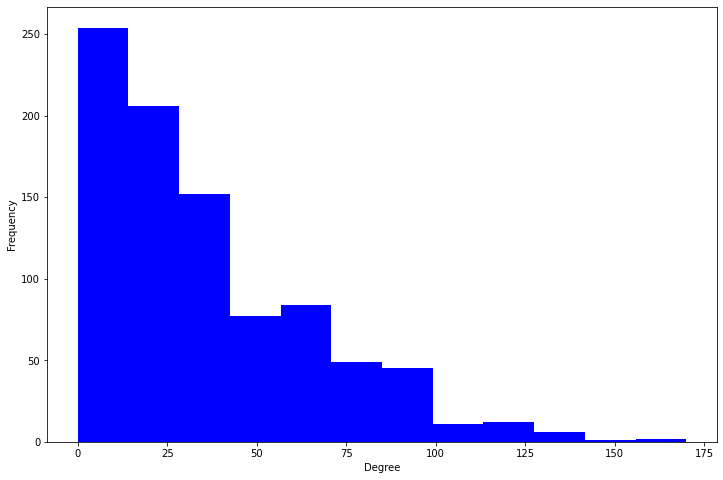

In [61]:
# Create Undirected graph 
plt.figure(figsize=(12,8))
g_23_27 = nx.from_numpy_matrix(adj_23_27)
g_23_27_tot = nx.from_numpy_matrix(adj_23_27)
plt.xlabel('Degree')
plt.ylabel("Frequency")
plt.grid(False)
degs_23_27 = np.array([x[1] for x in g_23_27.degree])
_ = plt.hist(degs_23_27, bins=12, color='blue')
plt.savefig('./plots/degree_23_29.eps')

In [62]:
sp.stats.entropy(np.histogram(degs_23_27, bins=12)[0])

1.9017853170418322

In [63]:
print(nx.average_clustering(g_23_27))

0.24215186567936373


## Plot Clusters ##

In [64]:
isolated_nodes_23_27 = []
for e in nx.connected_components(g_23_27):
    if len(e) < 3:
        isolated_nodes_23_27.append(e.pop())

isolated_nodes_23_27.extend(out_nodes)
isolated_nodes_23_27 = list(set(isolated_nodes_23_27))
g_23_27.remove_nodes_from(isolated_nodes_23_27)

for e in nx.connected_components(g_23_27):
    if len(e) < 3:
        print(e)

In [65]:
G_23_27 = pygsp.graphs.Graph(nx.adjacency_matrix(g_23_27))

G_23_27.compute_laplacian()
G_23_27.compute_fourier_basis()

In [66]:
import community 

max_mod_23_27 = 0
part_23_27 = None

for i in range(20):

    partition = community.best_partition(g_23_27, weight='weight')
    c_g = [set() for e in range(len(partition))]
    for k, v in partition.items():
        c_g[v].add(k)
    mod = community.modularity(partition, g_23_27, weight='weight')
    if max_mod_23_27 < mod:
        max_mod_23_27 = mod
        part_23_27 = partition


print("weighted coverage : {}".format(weighted_covergae(g_23_27, part_23_27)))

color_cluster = ['yellow', 'blue', 'red', 'gray', 'green']
vec_col_23_27 = [color_cluster[e] for e in part_23_27.values()]

In [69]:
plt.figure(figsize=(8, 12))

nx.draw_networkx_nodes(g_23_27, locations, node_size=60, node_color=vec_col_23_27)
# nx.draw_networkx_edges(g_23_27, locations, alpha=0.8, width=0.2, edge_color='black')

plt.grid(False)
_ = plt.axis('off')

plt.savefig('plots/weighted_cluster_23_27.jpeg')
mplleaflet.show()

In [70]:
upper_man_idx = c_g[2]
queens_idx = c_g[4]

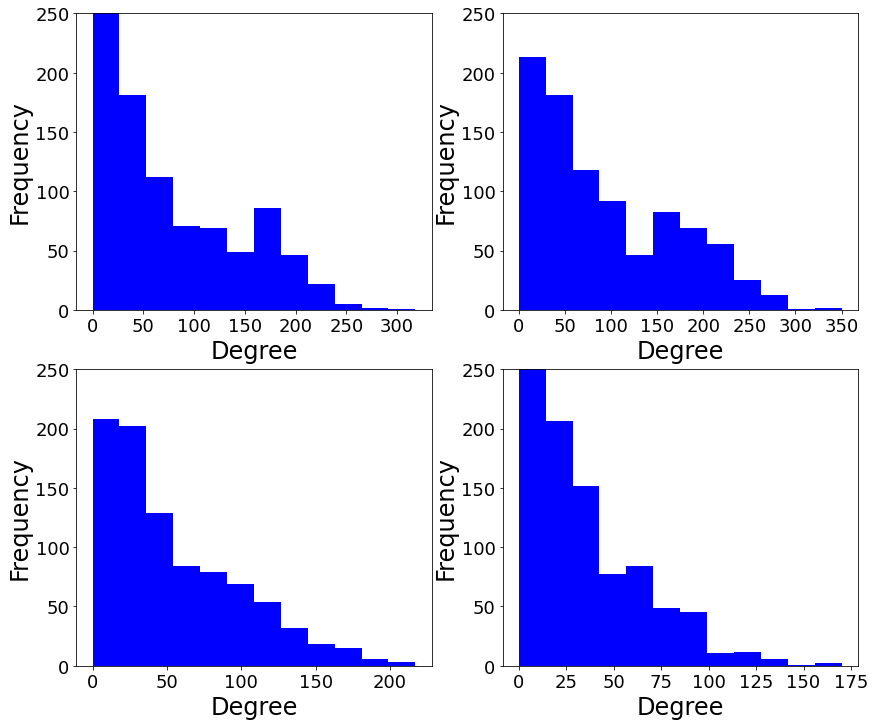

In [71]:
plt.figure(figsize=(14,12))

plt.subplot(2,2,1)
plt.xlabel('Degree', fontsize=24)
plt.ylabel("Frequency", fontsize=24)
plt.grid(False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0, 250)
_ = plt.hist(degs_2_6, bins=12, color='blue')

plt.subplot(2,2,2)
plt.xlabel('Degree', fontsize=24)
plt.ylabel("Frequency", fontsize=24)
plt.grid(False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0, 250)
_ = plt.hist(degs_9_13, bins=12, color='blue')

plt.subplot(2,2,3)
plt.xlabel('Degree', fontsize=24)
plt.ylabel("Frequency", fontsize=24)
plt.grid(False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0, 250)
_ = plt.hist(degs_16_20, bins=12, color='blue')

plt.subplot(2,2,4)
plt.xlabel('Degree', fontsize=24)
plt.ylabel("Frequency", fontsize=24)
plt.grid(False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0, 250)
_ = plt.hist(degs_23_27, bins=12, color='blue')

plt.savefig('plots/degs_hist.eps')

## Deg-Sorted Nodes over time ##

In [72]:
sort_deg = np.argsort(degs_2_6)

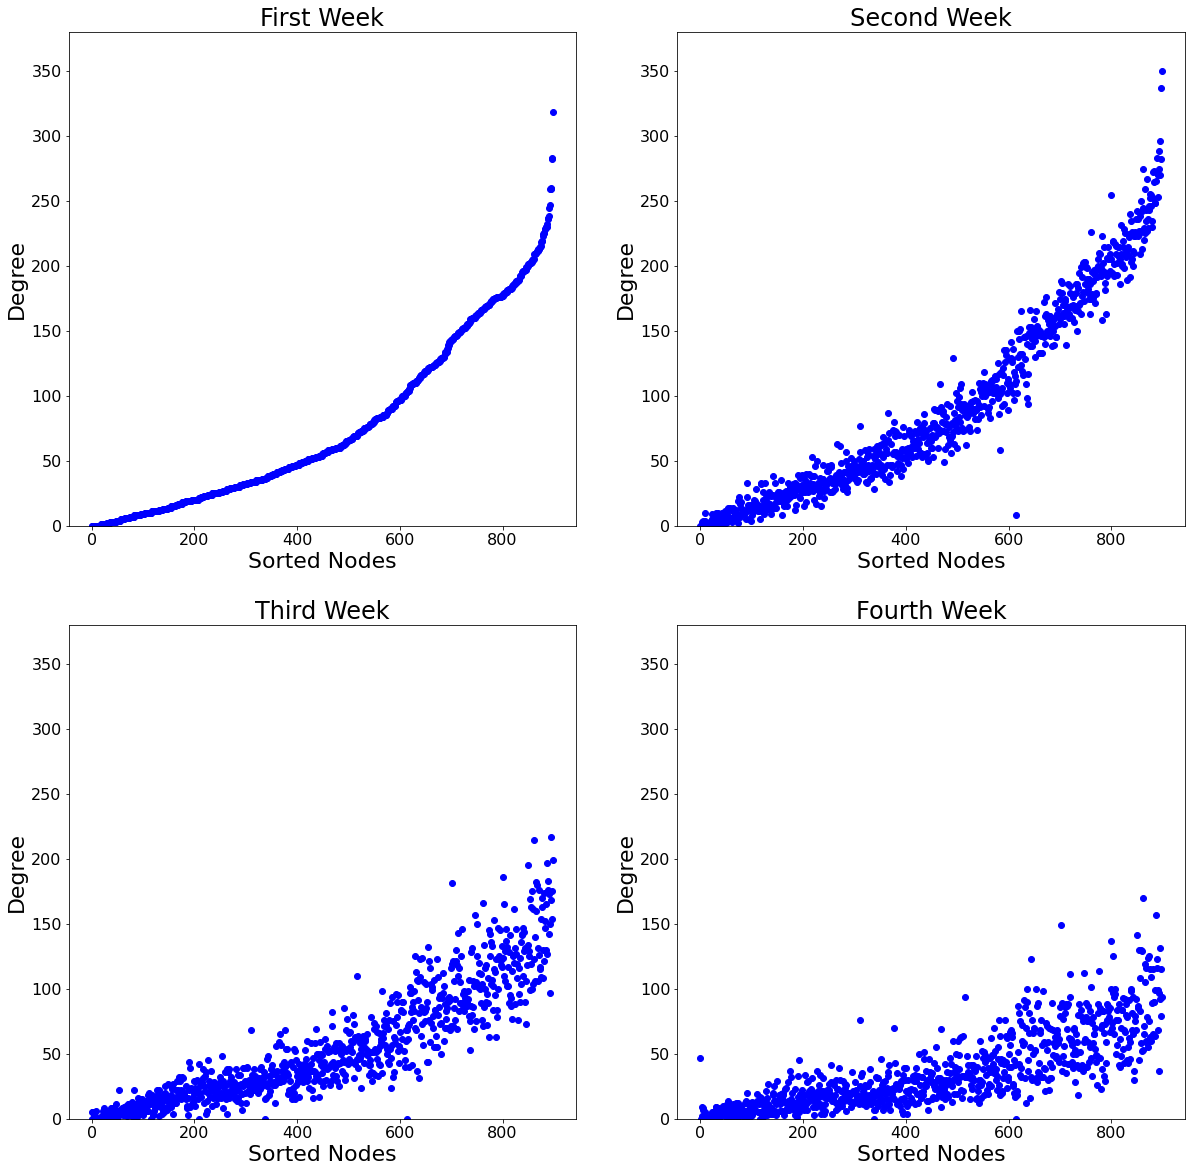

In [73]:
plt.figure(figsize=(20, 20))

plt.subplot(2,2,1)
plt.scatter(np.arange(len(degs_2_6)), degs_2_6[sort_deg], color='blue')
plt.xlabel('Sorted Nodes', fontsize=22)
plt.ylabel('Degree', fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,380)
plt.title("First Week", fontsize=24)
plt.grid(False)

plt.subplot(2,2,2)
plt.scatter(np.arange(n_tot_station), degs_9_13[sort_deg], color='blue')
plt.xlabel('Sorted Nodes', fontsize=22)
plt.ylabel('Degree', fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,380)
plt.title("Second Week", fontsize=24)
plt.grid(False)

plt.subplot(2,2,3)
plt.scatter(np.arange(n_tot_station), degs_16_20[sort_deg], color='blue')
plt.xlabel('Sorted Nodes', fontsize=22)
plt.ylabel('Degree', fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Third Week", fontsize=24)
plt.ylim(0,380)
plt.grid(False)

plt.subplot(2,2,4)
plt.scatter(np.arange(n_tot_station), degs_23_27[sort_deg], color='blue')
plt.xlabel('Sorted Nodes', fontsize=22)
plt.ylabel('Degree', fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Fourth Week", fontsize=24)
plt.ylim(0,380)
plt.grid(False)

plt.savefig('./plots/degree_ordered.eps')

# Flow #

In [74]:
queens = []
for k,v in part_2_6.items():
    if part_2_6[k]==4 and part_23_27.get(k) == 2:
        queens.append(k)

brooklyn = []
for k,v in part_2_6.items():
    if part_2_6[k]==2 and part_23_27.get(k) == 2:
        brooklyn.append(k)


astoria = []
for k,v in part_2_6.items():
    if part_2_6[k]==4 and part_23_27.get(k) == 4:
        astoria.append(k)

manhattan = []
for k,v in part_2_6.items():
    man = {0,1,3}
    if part_2_6[k] in man and part_23_27.get(k) in man:
        manhattan.append(k)
        
blue_last = []
for k,v in part_23_27.items():
    if part_23_27.get(k) == 1:
        blue_last.append(k)

yellow_last = []
for k,v in part_23_27.items():
    if part_23_27.get(k) == 0:
        yellow_last.append(k)

blue_first = []
for k,v in part_2_6.items():
    if part_2_6.get(k) == 1:
        blue_first.append(k)

gray_first = []
for k,v in part_2_6.items():
    if part_2_6.get(k) == 0:
        gray_first.append(k)

In [75]:
inn_1, out_1  = compute_flows(g_2_6, queens)
print("{:20s}   {:7d}     {:7d}".format("First Flow Queens", int(inn_1), int(out_1) ))

inn_4, out_4  = compute_flows(g_23_27, queens)
print("{:20s}   {:7d}     {:7d}".format("Last Flow Queens", int(inn_4), int(out_4) ))

print("{:20s}   {:2.5f}     {:2.5f}".format("Ratio", inn_4/inn_1, out_4/out_1))
print("\n")

inn_1, out_1  = compute_flows(g_2_6, brooklyn)
print("{:20s}   {:7d}     {:7d}".format("First Flow brooklyn", int(inn_1), int(out_1) ))

inn_4, out_4  = compute_flows(g_23_27, brooklyn)
print("{:20s}   {:7d}     {:7d}".format("Last Flow brooklyn", int(inn_4), int(out_4) ))

print("{:20s}   {:2.5f}     {:2.5f}".format("Ratio", inn_4/inn_1, out_4/out_1))
print("\n")

inn_1, out_1  = compute_flows(g_2_6, manhattan)
print("{:20s}   {:7d}     {:7d}".format("First Flow manhattan", int(inn_1), int(out_1) ))

inn_4, out_4  = compute_flows(g_23_27, manhattan)
print("{:20s}   {:7d}     {:7d}".format("Last Flow manhattan", int(inn_4), int(out_4) ))

print("{:20s}   {:2.5f}     {:2.5f}".format("Ratio", inn_4/inn_1, out_4/out_1))
print("\n")

inn_1, out_1  = compute_flows(g_2_6, astoria)
print("{:20s}   {:7d}     {:7d}".format("First Flow astoria", int(inn_1), int(out_1) ))

inn_4, out_4  = compute_flows(g_23_27, astoria)
print("{:20s}   {:7d}     {:7d}".format("Last Flow astoria", int(inn_4), int(out_4) ))

print("{:20s}   {:2.5f}     {:2.5f}".format("Ratio", inn_4/inn_1, out_4/out_1))
print("\n")

First Flow Queens        17992        4531
Last Flow Queens          5742        2211
Ratio                  0.31914     0.48797


First Flow brooklyn      39458        5069
Last Flow brooklyn       11132        2064
Ratio                  0.28212     0.40718


First Flow manhattan    375512        7144
Last Flow manhattan      91044        2430
Ratio                  0.24245     0.34015


First Flow astoria        7410        1684
Last Flow astoria         4086         750
Ratio                  0.55142     0.44537




In [76]:
flow_1 = compute_flows_between(g_2_6, queens, astoria)
flow_4 = compute_flows_between(g_23_27, queens, astoria)
print("{:25s}   {:7d}     {:7d}".format("Flows Queens/Astoria", int(flow_1), int(flow_4) ))

print("{:25s}   {:2.5f}".format("Ratio", flow_4/flow_1))
print("\n")

flow_1 = compute_flows_between(g_2_6, queens, brooklyn)
flow_4 = compute_flows_between(g_23_27, queens, brooklyn)
print("{:25s}   {:7d}     {:7d}".format("Flows Queens/Brooklyn", int(flow_1), int(flow_4) ))

print("{:25s}   {:2.5f}".format("Ratio", flow_4/flow_1))
print("\n")

flow_1 = compute_flows_between(g_2_6, astoria, manhattan)
flow_4 = compute_flows_between(g_23_27, astoria, manhattan)
print("{:25s}   {:7d}     {:7d}".format("Flows Astoria/Manhattan", int(flow_1), int(flow_4) ))

print("{:25s}   {:2.5f}".format("Ratio", flow_4/flow_1))
print("\n")

flow_1 = compute_flows_between(g_2_6, queens, manhattan)
flow_4 = compute_flows_between(g_23_27, queens, manhattan)
print("{:25s}   {:7d}     {:7d}".format("Flows Queens/Manhattan", int(flow_1), int(flow_4) ))

print("{:25s}   {:2.5f}".format("Ratio", flow_4/flow_1))
print("\n")

flow_1 = compute_flows_between(g_2_6, brooklyn, manhattan)
flow_4 = compute_flows_between(g_23_27, brooklyn, manhattan)
print("{:25s}   {:7d}     {:7d}".format("Flows Brooklyn/Manhattan", int(flow_1), int(flow_4) ))

print("{:25s}   {:2.5f}".format("Ratio", flow_4/flow_1))
print("\n")

flow_1 = compute_flows_between(g_2_6, blue_last, yellow_last)
flow_4 = compute_flows_between(g_23_27, blue_last, yellow_last)
print("{:25s}   {:7d}     {:7d}".format("Flows Blue/Yellow", int(flow_1), int(flow_4) ))

print("{:25s}   {:2.5f}".format("Ratio", flow_4/flow_1))
print("\n")

flow_1 = compute_flows_between(g_2_6, blue_first, gray_first)
flow_4 = compute_flows_between(g_23_27, blue_first, gray_first)
print("{:25s}   {:7d}     {:7d}".format("Flows Blue/Gray", int(flow_1), int(flow_4) ))

print("{:25s}   {:2.5f}".format("Ratio", flow_4/flow_1))
print("\n")

Flows Queens/Astoria            803         238
Ratio                       0.29639


Flows Queens/Brooklyn          1496        1102
Ratio                       0.73663


Flows Astoria/Manhattan         780         464
Ratio                       0.59487


Flows Queens/Manhattan         2107         810
Ratio                       0.38443


Flows Brooklyn/Manhattan       2649         745
Ratio                       0.28124


Flows Blue/Yellow             42311        6705
Ratio                       0.15847


Flows Blue/Gray                7645        3060
Ratio                       0.40026




In [77]:
# ORDER: UM LM BR MM AS WB
cluster_sets = [set() for e in range(1 + len(set(part_2_6.values())))]
out = []
for k,v in part_2_6.items():
    if k in set(list(g_23_27.nodes())):
        cluster_sets[v].add(k)
    else:
        out.append(k)

for e in cluster_sets[4]:
    if part_2_6[e] == 4 and part_23_27.get(e) == 2:
        cluster_sets[5].add(e)

for e in cluster_sets[5]:
    cluster_sets[4].remove(e)

In [78]:
# First Week

flows_vec_first = []
for e in cluster_sets:
    inn, out = compute_flows(g_2_6, e)
    flows_vec_first.append(inn+out)
    
flows_vec_first = np.array(flows_vec_first)

flow_matrix_first = np.zeros((len(flows_vec_first), len(flows_vec_first)))
for i in range(flow_matrix_first.shape[0]):
    for j in range(flow_matrix_first.shape[0]):
        flow_matrix_first[i,j] = compute_flows_between(g_2_6, cluster_sets[i], cluster_sets[j])

flow_matrix_first_ratio = flow_matrix_first / flows_vec_first[:, np.newaxis]

In [79]:
# Second Week

flows_vec_second = []
for e in cluster_sets:
    inn, out = compute_flows(g_23_27, e)
    flows_vec_second.append(inn+out)
    
flows_vec_second = np.array(flows_vec_second)

flow_matrix_second = np.zeros((len(flows_vec_second), len(flows_vec_second)))
for i in range(flow_matrix_second.shape[0]):
    for j in range(flow_matrix_second.shape[0]):
        flow_matrix_second[i,j] = compute_flows_between(g_23_27, cluster_sets[i], cluster_sets[j])

flow_matrix_second_ratio = flow_matrix_second / flows_vec_second[:, np.newaxis]

In [80]:
# First Week

flows_vec_first = []
for e in cluster_sets:
    inn, out = compute_flows(g_2_6, e)
    flows_vec_first.append(inn+out)
    
flows_vec_first = np.array(flows_vec_first)

flow_matrix_first = np.zeros((len(flows_vec_first), len(flows_vec_first)))
for i in range(flow_matrix_first.shape[0]):
    for j in range(flow_matrix_first.shape[0]):
        flow_matrix_first[i,j] = compute_flows_between(g_2_6, cluster_sets[i], cluster_sets[j])

flow_matrix_first_ratio = flow_matrix_first / flows_vec_first[:, np.newaxis]

In [81]:
import matplotlib.colors as colors

In [82]:
names = ['UM', 'LM', 'MM', 'BR', 'WB', 'AS']

In [83]:
color_cluster

['yellow', 'blue', 'red', 'gray', 'green']

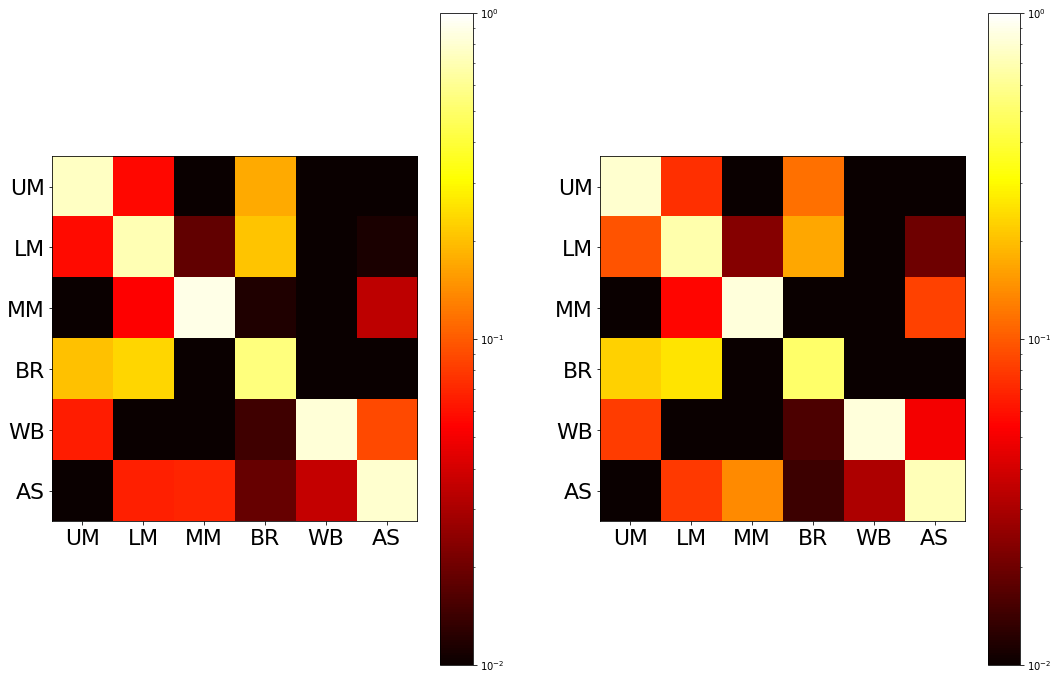

In [84]:
plt.figure(figsize=(18, 12))

plt.subplot(1,2,1)
cmap = plt.get_cmap('hot')
plt.imshow(flow_matrix_first_ratio, cmap=cmap, interpolation='nearest', norm=colors.LogNorm(vmin=0.01, vmax=1))
plt.grid(False)
plt.colorbar()
_= plt.xticks(np.arange(6), names, fontsize=22)
_= plt.yticks(np.arange(6), names, fontsize=22)


plt.subplot(1,2,2)
cmap = plt.get_cmap('hot')
plt.imshow(flow_matrix_second_ratio, cmap=cmap, interpolation='nearest', norm=colors.LogNorm(vmin=0.01, vmax=1))
plt.grid(False)
plt.colorbar()
_= plt.xticks(np.arange(6), names, fontsize=22)
_= plt.yticks(np.arange(6), names, fontsize=22)


In [85]:
mat = flow_matrix_second / flow_matrix_first

mat[[2, 3]] = mat[[3, 2]]
mat[:,[2, 3]] = mat[:,[3, 2]]

In [87]:
names

['UM', 'LM', 'MM', 'BR', 'WB', 'AS']

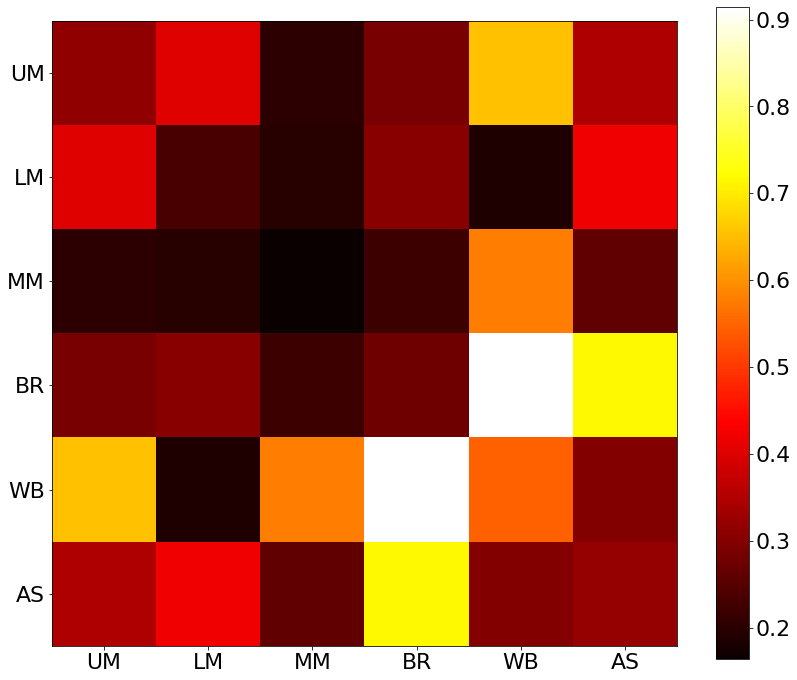

In [88]:
plt.figure(figsize=(14,12))
cmap = plt.get_cmap('hot')
plt.imshow(mat, cmap=cmap, interpolation='nearest')
plt.grid(False)

_= plt.xticks(np.arange(6), names, fontsize=22)
_= plt.yticks(np.arange(6), names, fontsize=22)
_ = plt.colorbar().ax.tick_params(labelsize=22)

plt.savefig('plots/heatmap_flows.eps')

In [89]:
for e in mat:
    s = ''
    for i in e:
        s += str(np.round(i, 4))
        s += '  '
    print(s)

0.3161  0.4017  0.2025  0.2881  0.6561  0.3495  
0.4017  0.2348  0.1986  0.3062  0.1887  0.4236  
0.2025  0.1986  0.1636  0.2201  0.5789  0.2611  
0.2881  0.3062  0.2201  0.2758  0.9143  0.7173  
0.6561  0.1887  0.5789  0.9143  0.546  0.3009  
0.3495  0.4236  0.2611  0.7173  0.3009  0.3191  


In [90]:
for e in flow_matrix_first_ratio:
    s = ''
    for i in e:
        s += str(np.round(i, 4))
        s += '  '
    print(s)

0.7626  0.0563  0.0013  0.1736  0.0045  0.0014  
0.0576  0.7012  0.0183  0.2076  0.0004  0.0113  
0.0039  0.0534  0.895  0.0116  0.0008  0.0344  
0.202  0.2361  0.0045  0.5514  0.0011  0.0037  
0.0656  0.0058  0.0038  0.0145  0.8219  0.0884  
0.0083  0.0666  0.0693  0.019  0.036  0.7988  


In [91]:
for e in flow_matrix_second_ratio:
    s = ''
    for i in e:
        s += str(np.round(i, 4))
        s += '  '
    print(s)

0.7963  0.0747  0.0012  0.1161  0.0096  0.0016  
0.0962  0.6846  0.0233  0.1715  0.0003  0.02  
0.0038  0.0558  0.842  0.0087  0.0024  0.0842  
0.2262  0.2592  0.0055  0.4989  0.0037  0.0053  
0.081  0.0021  0.0066  0.0158  0.8445  0.05  
0.0082  0.0798  0.1407  0.0141  0.0307  0.722  


In [92]:
color_cluster

['yellow', 'blue', 'red', 'gray', 'green']

In [93]:
def find_partitions(p):
    part = dict()
    for k, v in p.items():
        if part.get(v) is None:
            part[v] = [k]
        else:
            part[v].append(k)
    return part
    
    

In [94]:
from networkx.algorithms.centrality import betweenness_centrality_subset

In [95]:
p_2_6 = find_partitions(part_2_6)
val = []
for k, e in p_2_6.items():
    value = 0
    b_dict = betweenness_centrality_subset(g_2_6, e, e)
    for k, v in b_dict.items():
        if k in set(e):
            value += v
    val.append(value / len(e))
        

In [96]:
val

[69.88059840286138,
 18.141600223803806,
 96.6195153985256,
 2.3848315890769936,
 157.29393830136104]

In [97]:
p_23_27 = find_partitions(part_23_27)
val = []
for k, e in p_23_27.items():
    value = 0
    b_dict = betweenness_centrality_subset(g_23_27, e, e)
    for k, v in b_dict.items():
        if k in set(e):
            value += v
    val.append(value / len(e))
        

In [98]:
val

[30.73888344084618,
 33.0199127506528,
 283.95632337734537,
 74.97990208587099,
 35.99490481101065]

In [99]:
color_cluster

['yellow', 'blue', 'red', 'gray', 'green']

# Functions on Graphs #

In [100]:
f_2_6 = np.sum(adj_2_6_tot, axis=0)
f_9_13 = np.sum(adj_9_13_tot, axis=0)
f_16_20 = np.sum(adj_16_20_tot, axis=0)
f_23_27 = np.sum(adj_23_27_tot, axis=0)

rif = f_2_6 + 1

r_2_6 = rif / rif
r_9_13 = f_9_13 / rif
r_16_20 = f_16_20 / rif
r_23_27 = f_23_27 / rif

rif = degs_2_6 + 1

d_2_6 = rif / rif
d_9_13 = degs_9_13 / rif
d_16_20 = degs_16_20 / rif
d_23_37 = degs_23_27 / rif

f_2_6 = np.delete(f_2_6, isolated_nodes_2_6)
f_9_13 = np.delete(f_9_13, isolated_nodes_9_13)
f_16_20 = np.delete(f_16_20, isolated_nodes_16_20)
f_23_27 = np.delete(f_23_27, isolated_nodes_23_27)

r_2_6 = np.delete(r_2_6, isolated_nodes_2_6)
r_9_13 = np.delete(r_9_13, isolated_nodes_9_13)
r_16_20 = np.delete(r_16_20, isolated_nodes_16_20)
r_23_27 = np.delete(r_23_27, isolated_nodes_23_27)

d_2_6 = np.delete(d_2_6, isolated_nodes_2_6)
d_9_13 = np.delete(d_9_13, isolated_nodes_9_13)
d_16_20 = np.delete(d_16_20, isolated_nodes_16_20)
d_23_27 = np.delete(d_23_37, isolated_nodes_23_27)

# Clusters #

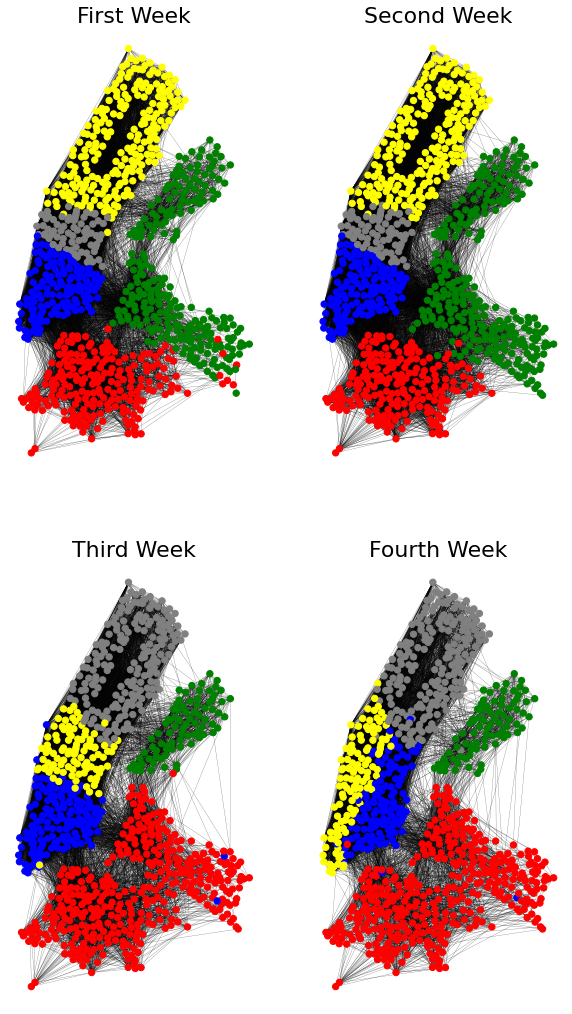

In [101]:
plt.figure(figsize=(10,18))
plt.subplot(2,2,1)

plt.grid(False)
plt.axis(False)
plt.title('First Week', fontsize=22)
nx.draw_networkx_nodes(g_2_6, locations, node_size=40, node_color=vec_col_2_6)
nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,2)
plt.grid(False)
plt.axis(False)
plt.title('Second Week', fontsize=22)
nx.draw_networkx_nodes(g_9_13, locations, node_size=40, node_color=vec_col_9_13)
nx.draw_networkx_edges(g_9_13, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,3)
plt.grid(False)
plt.axis(False)
plt.title('Third Week', fontsize=22)
nx.draw_networkx_nodes(g_16_20, locations, node_size=40, node_color=vec_col_16_20)
nx.draw_networkx_edges(g_16_20, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,4)
plt.grid(False)
plt.axis(False)
plt.title('Fourth Week', fontsize=22)
nx.draw_networkx_nodes(g_23_27, locations, node_size=40, node_color=vec_col_23_27)
nx.draw_networkx_edges(g_23_27, locations, alpha=0.8, width=0.2, edge_color='black')

plt.savefig('plots/clusters.jpeg')

In [102]:
weighted_covergae(g_2_6, part_2_6)

0.7126401913709719

In [103]:
weighted_covergae(g_9_13, part_9_13)

0.6831583444048612

In [104]:
weighted_covergae(g_16_20, part_16_20)

0.7182639426983917

In [105]:
weighted_covergae(g_23_27, part_23_27)

0.7381265502488722

# Graph over means

In [106]:
m_2_6 = f_2_6 / np.mean(f_2_6)
m_9_13 = f_9_13 / np.mean(f_9_13)
m_16_20 = f_16_20 / np.mean(f_16_20)
m_23_27 = f_23_27 / np.mean(f_23_27)

In [107]:
cmap= matplotlib.cm.get_cmap('jet')

In [108]:
print(np.mean(f_2_6))
print(np.mean(f_9_13))
print(np.mean(f_16_20))
print(np.mean(f_23_27))

586.0011350737798
653.5541760722348
309.45691609977325
193.6859410430839


In [109]:
print(np.max(m_2_6))
print(np.max(m_9_13))
print(np.max(m_16_20))
print(np.max(m_23_27))

8.672338150608116
7.537248143075974
5.7164661959910745
6.587984616375248


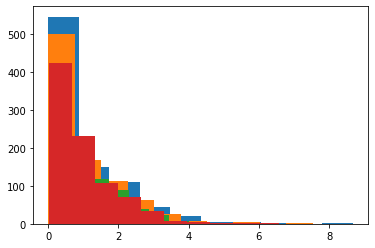

In [110]:
_ = plt.hist(m_2_6)
_ = plt.hist(m_9_13)
_ = plt.hist(m_16_20)
_ = plt.hist(m_23_27)

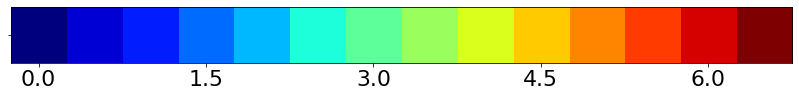

In [111]:
plt.figure(figsize=(14,15))
mat = np.arange(0, 7, 0.5)
label = np.array([round(x, 2) for x in mat])
mat = np.expand_dims(mat, axis=0)
plt.imshow(mat, origin="lower", cmap=cmap, interpolation='nearest')

plt.grid(False)
_ = plt.yticks([0], [''])
_ = plt.xticks([0, 3, 6, 9, 12], label[[0, 3, 6, 9, 12]], fontsize=22)
plt.set_cmap(cmap=cmap)

plt.savefig('plots/means_cmap.jpeg')

In [112]:
cmap= matplotlib.cm.get_cmap('jet')
plt.figure(figsize=(10,18))
plt.subplot(2,2,1)

plt.grid(False)
plt.axis(False)
nx.draw_networkx_nodes(g_2_6, locations, node_size=80, node_color=m_2_6, cmap=cmap, vmin=0, vmax=7)
# nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black')

mplleaflet.show()

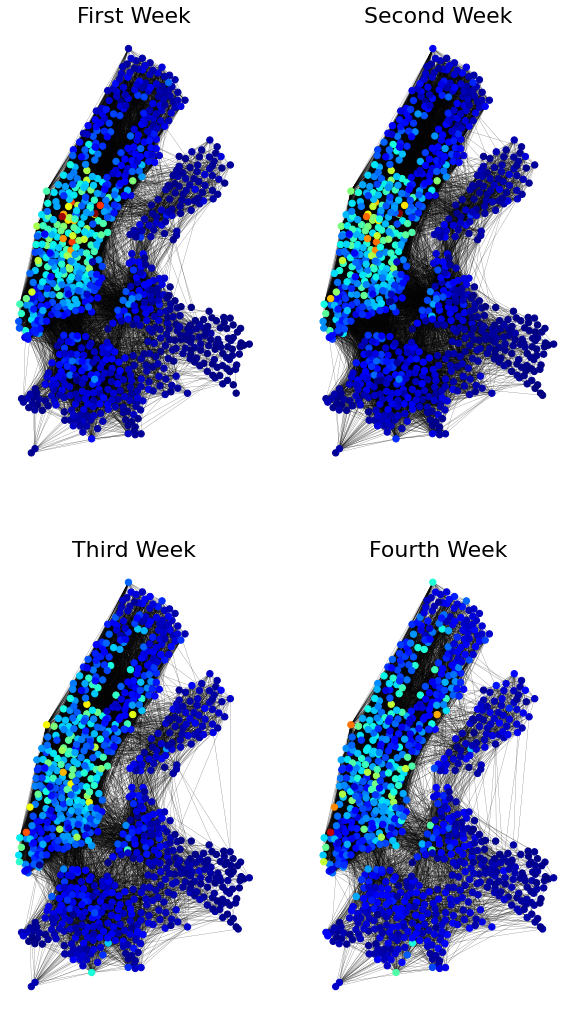

In [113]:
plt.figure(figsize=(10,18))
plt.subplot(2,2,1)

plt.grid(False)
plt.axis(False)
plt.title('First Week', fontsize=22)
nx.draw_networkx_nodes(g_2_6, locations, node_size=40, node_color=m_2_6, cmap=cmap, vmin=0, vmax=7)
nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,2)
plt.grid(False)
plt.axis(False)
plt.title('Second Week', fontsize=22)
nx.draw_networkx_nodes(g_9_13, locations, node_size=40, node_color=m_9_13, cmap=cmap, vmin=0, vmax=7)
nx.draw_networkx_edges(g_9_13, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,3)
plt.grid(False)
plt.axis(False)
plt.title('Third Week', fontsize=22)
nx.draw_networkx_nodes(g_16_20, locations, node_size=40, node_color=m_16_20, cmap=cmap, vmin=0, vmax=7)
nx.draw_networkx_edges(g_16_20, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,4)
plt.grid(False)
plt.axis(False)
plt.title('Fourth Week', fontsize=22)
nx.draw_networkx_nodes(g_23_27, locations, node_size=40, node_color=m_23_27, cmap=cmap, vmin=0, vmax=7)
nx.draw_networkx_edges(g_23_27, locations, alpha=0.8, width=0.2, edge_color='black')

plt.savefig('plots/over_means.jpeg')

In [114]:
rev = dict(zip(list(id_index.values()), list(id_index.keys())))


In [115]:
df[df['start station id'] == rev[117]]

tripduration                 starttime                  stoptime  \
165               292  2020-03-01 00:20:02.6310  2020-03-01 00:24:54.9380   
4427              382  2020-03-01 10:32:08.5320  2020-03-01 10:38:31.1000   
6612              360  2020-03-01 11:33:12.0730  2020-03-01 11:39:12.7500   
6996             1155  2020-03-01 11:42:37.6510  2020-03-01 12:01:52.7810   
7024               76  2020-03-01 11:43:25.0760  2020-03-01 11:44:41.6750   
...               ...                       ...                       ...   
1066802           756  2020-03-31 19:37:28.7130  2020-03-31 19:50:05.0380   
1067242            97  2020-03-31 20:10:06.2260  2020-03-31 20:11:44.1390   
1067301          1458  2020-03-31 20:15:07.6200  2020-03-31 20:39:25.8880   
1067881          1399  2020-03-31 21:26:09.0170  2020-03-31 21:49:28.6270   
1067882          1392  2020-03-31 21:26:12.4840  2020-03-31 21:49:25.3700   

         start station id  start station name  start station latitude  \
165                   359  E 47 St & Park Ave               40.755103   
4427                  359  E 47 St & Park Ave               40.755103   
6612                  359  E 47 St & Park Ave               40.755103   
6996                  359  E 47 St & Park Ave               40.755103   
7024                  359  E 47 St & Park Ave               40.755103   
...                   ...                 ...                     ...   
1066802               359  E 47 St & Park Ave               40.755103   
1067242               359  E 47 St & Park Ave               40.755103   
1067301               359  E 47 St & Park Ave               40.755103   
1067881               359  E 47 St & Park Ave               40.755103   
1067882               359  E 47 St & Park Ave               40.755103   

         start station longitude  end station id  \
165                   -73.974987             173   
4427                  -73.974987            2021   
6612                  -73.974987            3687   
6996                  -73.974987            3151   
7024                  -73.974987             359   
...                          ...             ...   
1066802               -73.974987            3156   
1067242               -73.974987             164   
1067301               -73.974987            3374   
1067881               -73.974987            3325   
1067882               -73.974987            3325   

                                      end station name  end station latitude  \
165                                 Broadway & W 49 St             40.760683   
4427                                   W 45 St & 8 Ave             40.759291   
6612                                   E 33 St & 1 Ave             40.743227   
6996                                E 81 St & York Ave             40.772838   
7024                                E 47 St & Park Ave             40.755103   
...                                                ...                   ...   
1066802                             E 72 St & York Ave             40.766638   
1067242                                E 47 St & 2 Ave             40.753231   
1067301  Central Park North & Adam Clayton Powell Blvd             40.799484   
1067881                                E 95 St & 3 Ave             40.784903   
1067882                                E 95 St & 3 Ave             40.784903   

         end station longitude  bikeid    usertype  birth year  gender  
165                 -73.984527   28326  Subscriber        1988       1  
4427                -73.988597   39952  Subscriber        1981       1  
6612                -73.974498   36555  Subscriber        1994       1  
6996                -73.949892   32988  Subscriber        1990       1  
7024                -73.974987   18737    Customer        1987       1  
...                        ...     ...         ...         ...     ...  
1066802             -73.953483   35257  Subscriber        1976       1  
1067242             -73.970325   4155

In [116]:
cmap= matplotlib.cm.get_cmap('jet')

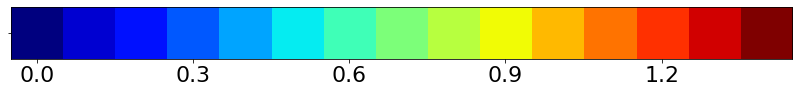

In [117]:
plt.figure(figsize=(14,15))
mat = np.arange(0, 1.5, 0.1)
label = np.array([round(x, 2) for x in mat])
mat = np.expand_dims(mat, axis=0)
plt.imshow(mat, origin="lower", cmap=cmap, interpolation='nearest')

plt.grid(False)
_ = plt.yticks([0], [''])
_ = plt.xticks([0, 3, 6, 9, 12], label[[0, 3, 6, 9, 12]], fontsize=22)
plt.set_cmap(cmap=cmap)

plt.savefig('plots/relative_cmap.jpeg')

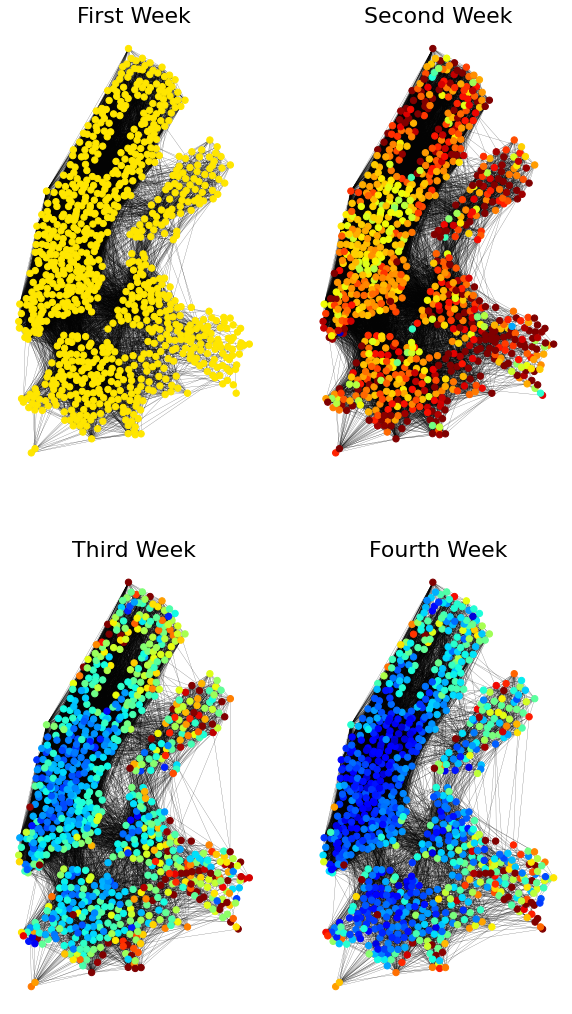

In [118]:
plt.figure(figsize=(10,18))
plt.subplot(2,2,1)

plt.grid(False)
plt.axis(False)
plt.title('First Week', fontsize=22)
nx.draw_networkx_nodes(g_2_6, locations, node_size=40, node_color=r_2_6, cmap=cmap, vmin=0, vmax=1.5)
nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,2)
plt.grid(False)
plt.axis(False)
plt.title('Second Week', fontsize=22)
nx.draw_networkx_nodes(g_9_13, locations, node_size=40, node_color=r_9_13, cmap=cmap, vmin=0, vmax=1.5)
nx.draw_networkx_edges(g_9_13, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,3)
plt.grid(False)
plt.axis(False)
plt.title('Third Week', fontsize=22)
nx.draw_networkx_nodes(g_16_20, locations, node_size=40, node_color=r_16_20, cmap=cmap, vmin=0, vmax=1.5)
nx.draw_networkx_edges(g_16_20, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,4)
plt.grid(False)
plt.axis(False)
plt.title('Fourth Week', fontsize=22)
nx.draw_networkx_nodes(g_23_27, locations, node_size=40, node_color=r_23_27, cmap=cmap, vmin=0, vmax=1.5)
nx.draw_networkx_edges(g_23_27, locations, alpha=0.8, width=0.2, edge_color='black')

plt.savefig('plots/ratio_first_week.jpeg')

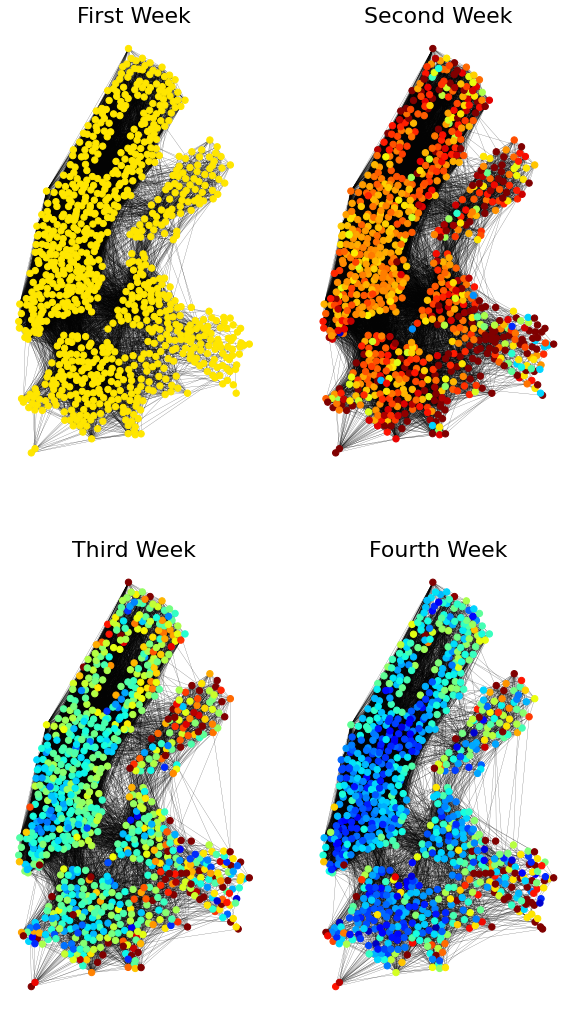

In [119]:
plt.figure(figsize=(10,18))
plt.subplot(2,2,1)

plt.grid(False)
plt.axis(False)
plt.title('First Week', fontsize=22)
nx.draw_networkx_nodes(g_2_6, locations, node_size=40, node_color=d_2_6, cmap=cmap, vmin=0, vmax=1.5)
nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,2)
plt.grid(False)
plt.axis(False)
plt.title('Second Week', fontsize=22)
nx.draw_networkx_nodes(g_9_13, locations, node_size=40, node_color=d_9_13, cmap=cmap, vmin=0, vmax=1.5)
nx.draw_networkx_edges(g_9_13, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,3)
plt.grid(False)
plt.axis(False)
plt.title('Third Week', fontsize=22)
nx.draw_networkx_nodes(g_16_20, locations, node_size=40, node_color=d_16_20, cmap=cmap, vmin=0, vmax=1.5)
nx.draw_networkx_edges(g_16_20, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(2,2,4)
plt.grid(False)
plt.axis(False)
plt.title('Fourth Week', fontsize=22)
nx.draw_networkx_nodes(g_23_27, locations, node_size=40, node_color=d_23_27, cmap=cmap, vmin=0, vmax=1.5)
nx.draw_networkx_edges(g_23_27, locations, alpha=0.8, width=0.2, edge_color='black')

plt.savefig('plots/ratio_deg_first_week.jpeg')

# First Weekend #

In [159]:
# 9 -> Monday
# Choose day 
days = [7, 8]

# Find all connections with weights
adj_78_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_78_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_78_tot[id_index[row['end station id']], id_index[row['start station id']]] += 1
    print('Day {} loaded...'.format(day))
    

Day 7 loaded...
Day 8 loaded...


In [160]:
ths = 1

In [161]:
adj_78 = adj_78_tot.copy()
adj_78[adj_78 <= ths] = 0
"""adj_23_27[adj_23_27 >= ths] = 1"""
print("Unweighted number of rides : {}".format(np.sum(adj_78) / 2))

# Remove Self-loops
for i in range(n_tot_station):
    adj_78[i, i] = 0

Unweighted number of rides : 68677.0


In [162]:
g_78 = nx.from_numpy_matrix(adj_78)

In [163]:
isolated_nodes_78 = []
for e in nx.connected_components(g_78):
    if len(e) < 3:
        isolated_nodes_78.append(e.pop())

isolated_nodes_78.extend(out_nodes)
isolated_nodes_78 = list(set(isolated_nodes_78))
g_78.remove_nodes_from(isolated_nodes_78)

for e in nx.connected_components(g_78):
    if len(e) < 3:
        print(e)

In [178]:
max_mod_78 = 0
part_78 = None

for i in range(20):

    partition = community.best_partition(g_78, weight='weight')
    c_g = [set() for e in range(len(partition))]
    for k, v in partition.items():
        c_g[v].add(k)
    mod = community.modularity(partition, g_78, weight='weight')
    if max_mod_78 < mod:
        max_mod_78 = mod
        part_78 = partition


print("weighted coverage : {}".format(weighted_covergae(g_78, part_78)))

color_cluster = ['yellow', 'blue', 'red', 'gray', 'green']
vec_col_78 = [color_cluster[e] for e in part_78.values()]

weighted coverage : 0.7639316084675231


In [ ]:
mat = flow_matrix_second / flow_matrix_first

mat[[2, 3]] = mat[[3, 2]]
mat[:,[2, 3]] = mat[:,[3, 2]]

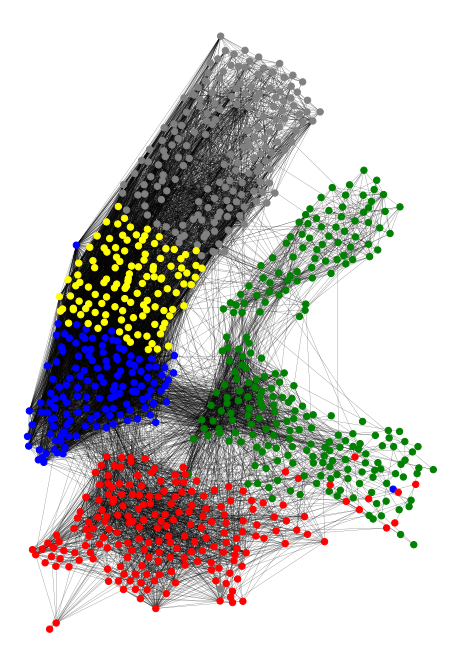

In [179]:
plt.figure(figsize=(8, 12))

nx.draw_networkx_nodes(g_78, locations, node_size=40, node_color=vec_col_78)
nx.draw_networkx_edges(g_78, locations, alpha=0.8, width=0.2, edge_color='black')

plt.grid(False)
_ = plt.axis('off')

# plt.savefig('plots/weighted_cluster_16_20.jpeg')

#mplleaflet.show()

# Second Weekdend #

In [166]:
# 9 -> Monday
# Choose day 
days = [14, 15]

# Find all connections with weights
adj_1415_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        adj_1415_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
        adj_1415_tot[id_index[row['end station id']], id_index[row['start station id']]] += 1
    print('Day {} loaded...'.format(day))
    

Day 14 loaded...
Day 15 loaded...


In [167]:
adj_1415 = adj_1415_tot.copy()
adj_1415[adj_1415 <= ths] = 0
"""adj_23_27[adj_23_27 >= ths] = 1"""
print("Unweighted number of rides : {}".format(np.sum(adj_78) / 2))

# Remove Self-loops
for i in range(n_tot_station):
    adj_1415[i, i] = 0

Unweighted number of rides : 66324.0


In [171]:
g_1415 = nx.from_numpy_matrix(adj_1415)

In [172]:
isolated_nodes_1415 = []
for e in nx.connected_components(g_1415):
    if len(e) < 3:
        isolated_nodes_1415.append(e.pop())

isolated_nodes_1415.extend(out_nodes)
isolated_nodes_1415 = list(set(isolated_nodes_1415))
g_1415.remove_nodes_from(isolated_nodes_1415)

for e in nx.connected_components(g_1415):
    if len(e) < 3:
        print(e)

In [176]:
max_mod_1415 = 0
part_1415 = None

for i in range(20):

    partition = community.best_partition(g_1415, weight='weight')
    c_g = [set() for e in range(len(partition))]
    for k, v in partition.items():
        c_g[v].add(k)
    mod = community.modularity(partition, g_1415, weight='weight')
    if max_mod_1415 < mod:
        max_mod_1415 = mod
        part_1415 = partition


print("weighted coverage : {}".format(weighted_covergae(g_1415, part_1415)))

color_cluster = ['yellow', 'blue', 'red', 'gray', 'green']
vec_col_1415 = [color_cluster[e] for e in part_1415.values()]

weighted coverage : 0.7336350855536125


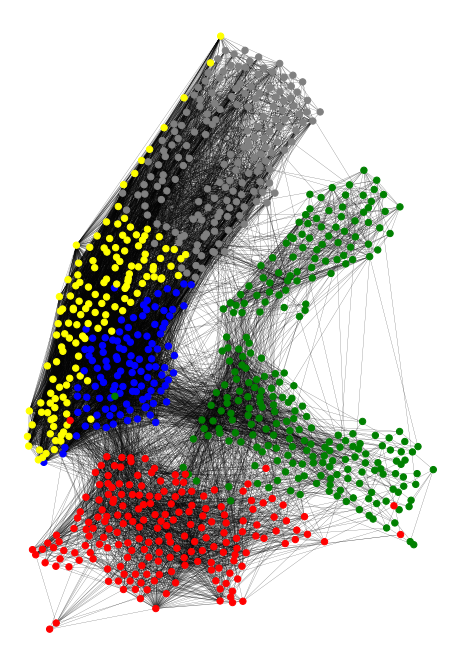

In [177]:
plt.figure(figsize=(8, 12))

nx.draw_networkx_nodes(g_1415, locations, node_size=40, node_color=vec_col_1415)
nx.draw_networkx_edges(g_1415, locations, alpha=0.8, width=0.2, edge_color='black')

plt.grid(False)
_ = plt.axis('off')

# plt.savefig('plots/weighted_cluster_16_20.jpeg')

#mplleaflet.show()

# DiGraph Analysis #

In [208]:
# FIRST WEEK
# Choose day 
days = [2, 3, 4, 5, 6]

# Find all connections with weights
dadj_2_6_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        dadj_2_6_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
    print('Day {} loaded...'.format(day))
    

dadj_2_6 = dadj_2_6_tot.copy()
dadj_2_6[dadj_2_6 <= ths] = 0
"""adj_23_27[adj_23_27 >= ths] = 1"""


# Remove Self-loops
for i in range(n_tot_station):
    dadj_2_6[i, i] = 0
    
print("Weighted number of rides : {}".format(np.sum(dadj_2_6)))

dg_2_6 = nx.from_numpy_matrix(dadj_2_6, create_using=nx.DiGraph)

dg_2_6.remove_nodes_from(out_nodes)

Day 2 loaded...
Day 3 loaded...
Day 4 loaded...
Day 5 loaded...
Day 6 loaded...
Weighted number of rides : 214895.0


In [209]:
# LAST WEEK
# Choose day 
days = [23, 24, 25, 26, 27]

# Find all connections with weights
dadj_23_27_tot = np.zeros((n_tot_station, n_tot_station))
for day in days:
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        dadj_23_27_tot[id_index[row['start station id']], id_index[row['end station id']]] += 1
    print('Day {} loaded...'.format(day))
    

dadj_23_27 = dadj_23_27_tot.copy()
dadj_23_27[dadj_23_27 <= ths] = 0
"""adj_23_27[adj_23_27 >= ths] = 1"""


# Remove Self-loops
for i in range(n_tot_station):
    dadj_23_27[i, i] = 0
    
print("Weighted number of rides : {}".format(np.sum(dadj_23_27)))

dg_23_27 = nx.from_numpy_matrix(dadj_23_27, create_using=nx.DiGraph)

dg_23_27.remove_nodes_from(out_nodes)

Day 23 loaded...
Day 24 loaded...
Day 25 loaded...
Day 26 loaded...
Day 27 loaded...
Weighted number of rides : 49842.0


In [210]:
# First Week

d_flows_vec_first = []
for e in cluster_sets:
    inn, out = compute_flows(dg_2_6, e)
    d_flows_vec_first.append(inn+out)
    
d_flows_vec_first = np.array(d_flows_vec_first)

d_flow_matrix_first = np.zeros((len(d_flows_vec_first), len(d_flows_vec_first)))
for i in range(d_flow_matrix_first.shape[0]):
    for j in range(d_flow_matrix_first.shape[0]):
        d_flow_matrix_first[i,j] = compute_flows_between(dg_2_6, cluster_sets[i], cluster_sets[j])

d_flow_matrix_first_ratio = d_flow_matrix_first / d_flows_vec_first[:, np.newaxis]

In [211]:
# Last Week

d_flows_vec_last = []
for e in cluster_sets:
    inn, out = compute_flows(dg_23_27, e)
    d_flows_vec_last.append(inn+out)
    
d_flows_vec_last = np.array(d_flows_vec_last)

d_flow_matrix_last = np.zeros((len(d_flows_vec_last), len(d_flows_vec_last)))
for i in range(d_flow_matrix_last.shape[0]):
    for j in range(d_flow_matrix_last.shape[0]):
        d_flow_matrix_last[i,j] = compute_flows_between(dg_23_27, cluster_sets[i], cluster_sets[j])

d_flow_matrix_last_ratio = d_flow_matrix_last / d_flows_vec_last[:, np.newaxis]

In [214]:
mat = d_flow_matrix_last / d_flow_matrix_first

mat[[2, 3]] = mat[[3, 2]]
mat[:,[2, 3]] = mat[:,[3, 2]]

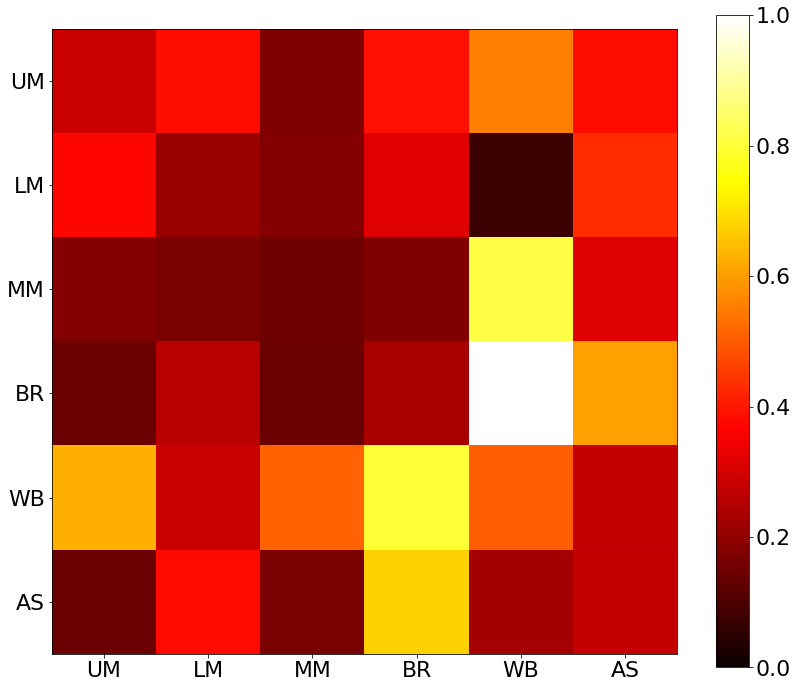

In [218]:
plt.figure(figsize=(14,12))
cmap = plt.get_cmap('hot')
plt.imshow(mat, cmap=cmap, interpolation='nearest', vmin=0, vmax=1)
plt.grid(False)

_= plt.xticks(np.arange(6), names, fontsize=22)
_= plt.yticks(np.arange(6), names, fontsize=22)
_ = plt.colorbar().ax.tick_params(labelsize=22)

plt.savefig('plots/d_heatmap_flows.eps')

# 1) Temporal Analysis # 

## Weekly days #

In [120]:
# First Week 
hour_full_2_8 = []
j = 1
# plt.figure(figsize=(12,8))

for i in [2, 3, 4, 5, 6, 7, 8]:
    # plt.subplot(2,3,j)
    hours = hour_rides(d[i], d[i+1], df)

    h_rides = [len(v) for k,v in hours.items()]
    hour_full_2_8.extend(h_rides)
    # plt.plot(h_rides)
    j += 1
    1

In [121]:
# Second Week
hour_full_9_15 = []
j = 1
# plt.figure(figsize=(12,8))

for i in [9, 10, 11, 12, 13, 14, 15]:
    # plt.subplot(2,3,j)
    hours = hour_rides(d[i], d[i+1], df)

    h_rides = [len(v) for k,v in hours.items()]
    hour_full_9_15.extend(h_rides)
    # plt.plot(h_rides)
    j += 1


In [122]:
# Third Week
hour_full_16_22 = []
j = 1
# plt.figure(figsize=(12,8))

for i in [16, 17, 18, 19, 20, 21, 22]:
    # plt.subplot(2,3,j)
    hours = hour_rides(d[i], d[i+1], df)

    h_rides = [len(v) for k,v in hours.items()]
    hour_full_16_22.extend(h_rides)
    # plt.plot(h_rides)
    j += 1


In [123]:
# Fourth Week
hour_full_23_29 = []
j = 1
# plt.figure(figsize=(12,8))

for i in [23, 24, 25, 26, 27, 28, 29]:
    # plt.subplot(2,3,j)
    hours = hour_rides(d[i], d[i+1], df)

    h_rides = [len(v) for k,v in hours.items()]
    hour_full_23_29.extend(h_rides)
    # plt.plot(h_rides)
    j += 1


In [124]:
full_month = []
full_month.extend(hour_full_2_8)
full_month.extend(hour_full_9_15)
full_month.extend(hour_full_16_22)
full_month.extend(hour_full_23_29)

In [125]:
# rain = [[24,30],[36,42], [108,114],[114,120],[270,276],[366,372],[408,414],[414,420],[510,516],[516,520],[564,570], [630, 636]]
weekend = [[120, 167], [287,335], [455, 503], [623, 671]]

In [126]:
with open('./data/python_variables/weekedns.pickle', 'wb') as file:
    pickle.dump(weekend, file)

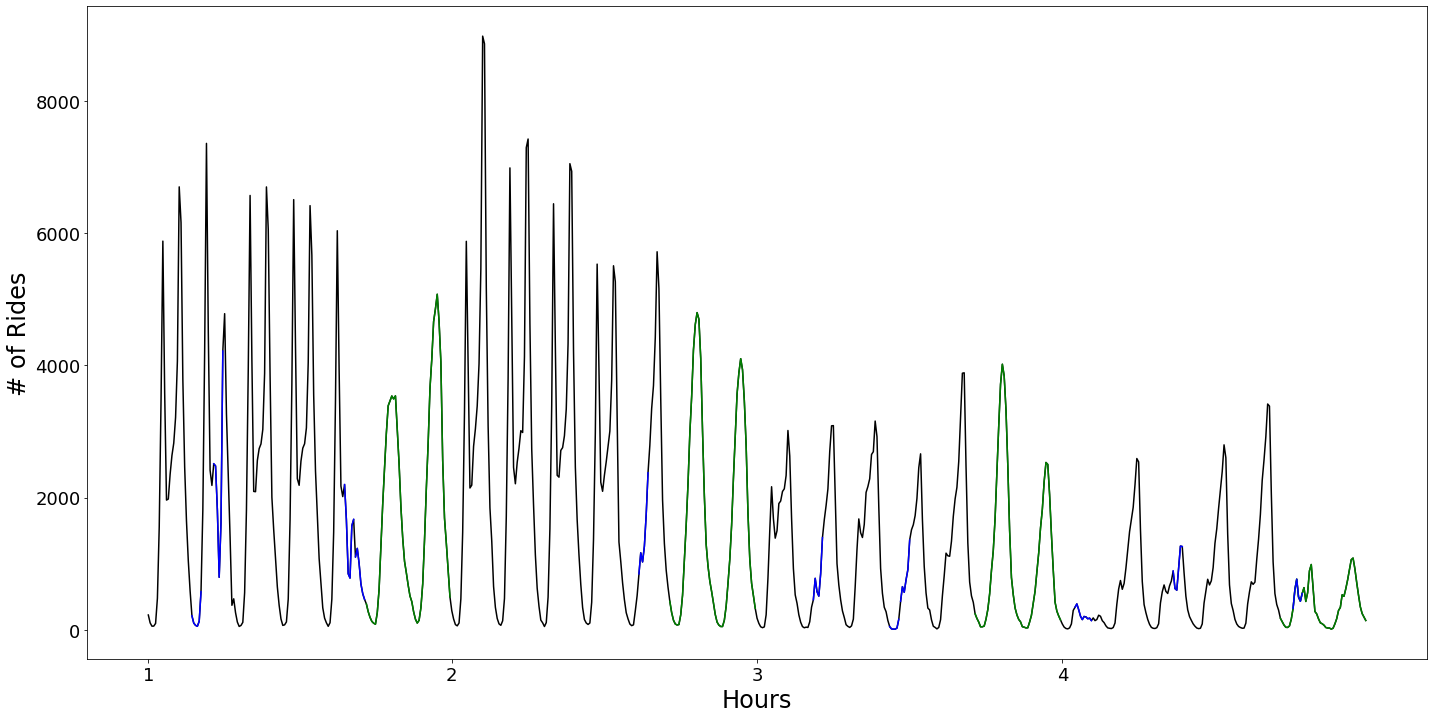

In [127]:
plt.figure(figsize=(24,12))
_ = plt.plot(full_month, color='black')
_ = plt.plot(np.arange(120, 167), hour_full_2_8[120:], color='green')
_ = plt.plot(np.arange(287, 335), hour_full_9_15[120:], color='green')
_ = plt.plot(np.arange(455, 503), hour_full_16_22[120:], color='green')
_ = plt.plot(np.arange(623, 671), hour_full_23_29[120:], color='green')


_ = plt.plot(np.arange(24, 30), full_month[24:30], color='blue')
_ = plt.plot(np.arange(36, 42), full_month[36:42], color='blue')
_ = plt.plot(np.arange(108, 114), full_month[108:114], color='blue')
_ = plt.plot(np.arange(114, 120), full_month[114:120], color='blue')
_ = plt.plot(np.arange(270, 276), full_month[270:276], color='blue')
_ = plt.plot(np.arange(366, 372), full_month[366:372], color='blue')
_ = plt.plot(np.arange(408, 414), full_month[408:414], color='blue')
_ = plt.plot(np.arange(414, 420), full_month[414:420], color='blue')
_ = plt.plot(np.arange(510, 516), full_month[510:516], color='blue')
_ = plt.plot(np.arange(516, 520), full_month[516:520], color='blue')
_ = plt.plot(np.arange(564, 570), full_month[564:570], color='blue')
_ = plt.plot(np.arange(630, 636), full_month[630:636], color='blue')


_ = plt.xticks([0, 167, 335, 503], np.arange(1, 5), fontsize=18)

_ = plt.xlabel('Hours', fontsize=24)
_ = plt.ylabel('# of Rides', fontsize=24)
_ = plt.yticks(fontsize=18)
plt.grid(False)
plt.savefig('./plots/hours_rides.eps')

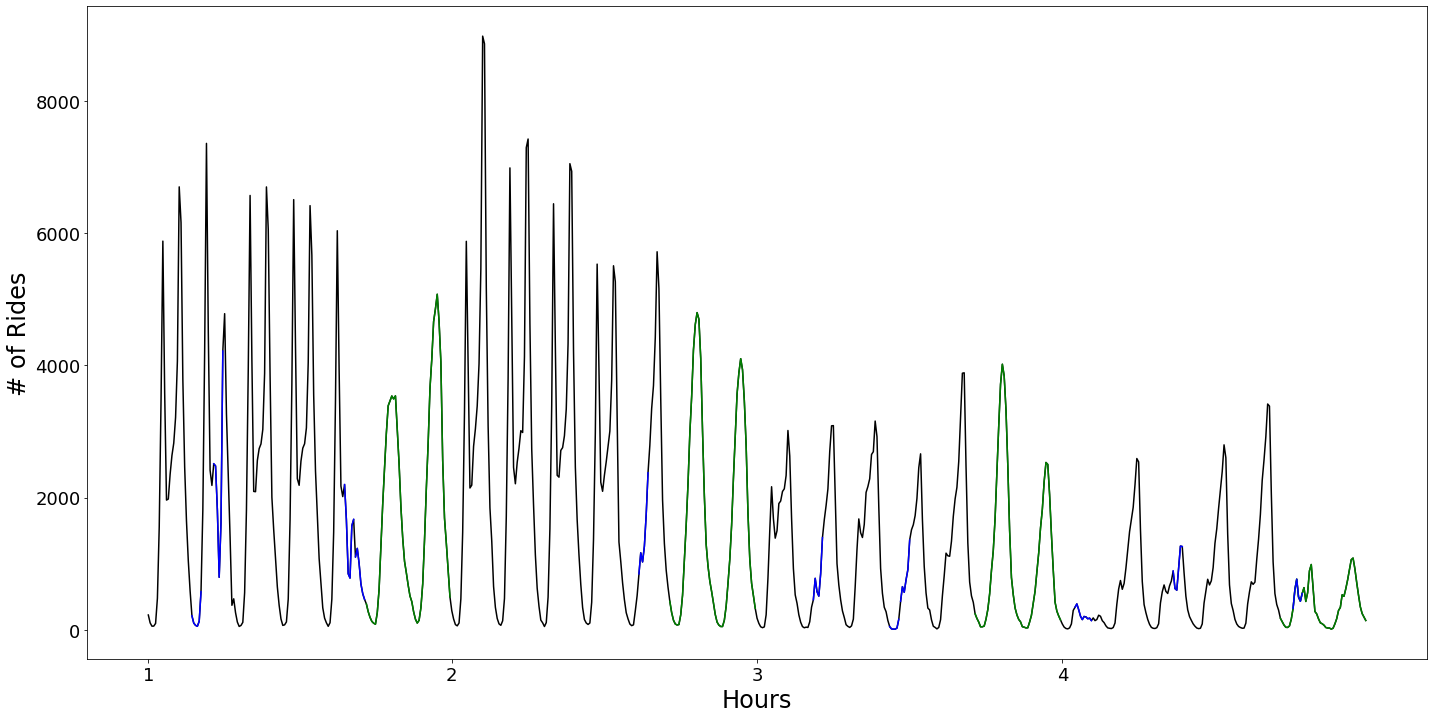

In [128]:
# Rain + Weekends, handcrafted

plt.figure(figsize=(24,12))
_ = plt.plot(full_month, color='black')
_ = plt.plot(np.arange(120, 167), hour_full_2_8[120:], color='green')
_ = plt.plot(np.arange(287, 335), hour_full_9_15[120:], color='green')
_ = plt.plot(np.arange(455, 503), hour_full_16_22[120:], color='green')
_ = plt.plot(np.arange(623, 671), hour_full_23_29[120:], color='green')


_ = plt.plot(np.arange(24, 30), full_month[24:30], color='blue')
_ = plt.plot(np.arange(36, 42), full_month[36:42], color='blue')
_ = plt.plot(np.arange(108, 114), full_month[108:114], color='blue')
_ = plt.plot(np.arange(114, 120), full_month[114:120], color='blue')
_ = plt.plot(np.arange(270, 276), full_month[270:276], color='blue')
_ = plt.plot(np.arange(366, 372), full_month[366:372], color='blue')
_ = plt.plot(np.arange(408, 414), full_month[408:414], color='blue')
_ = plt.plot(np.arange(414, 420), full_month[414:420], color='blue')
_ = plt.plot(np.arange(510, 516), full_month[510:516], color='blue')
_ = plt.plot(np.arange(516, 520), full_month[516:520], color='blue')
_ = plt.plot(np.arange(564, 570), full_month[564:570], color='blue')
_ = plt.plot(np.arange(630, 636), full_month[630:636], color='blue')


_ = plt.xticks([0, 167, 335, 503], np.arange(1, 5), fontsize=18)

_ = plt.xlabel('Hours', fontsize=24)
_ = plt.ylabel('# of Rides', fontsize=24)
_ = plt.yticks(fontsize=18)
plt.grid(False)
plt.savefig('./plots/hours_rides.eps')

# Trip Duration #

In [129]:
# Set last day
d[32] = -1

In [130]:
td = []
days = np.arange(1, 32)
out = []
for day in days:
    ti = []
    for index, row in df.iloc[d[day]:d[day+1]].iterrows():
        if row['tripduration'] < 3600:
            ti.append(row['tripduration'] )
        else:
            out.append(row['tripduration'])
    td.append(ti)

    

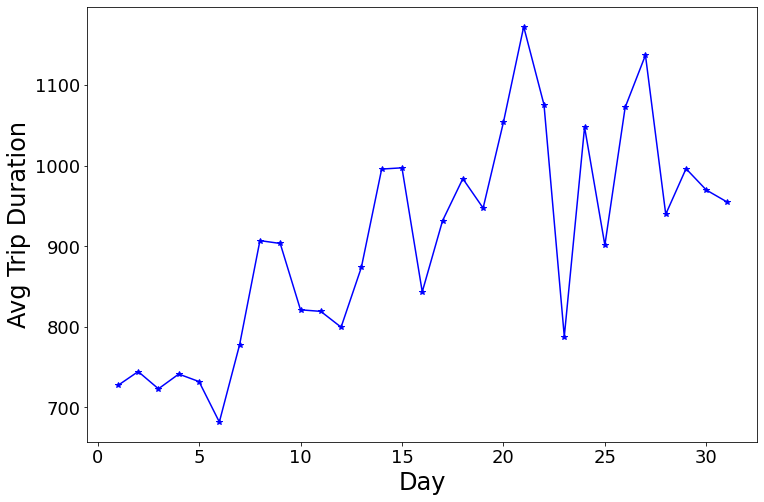

In [223]:
m = [np.mean(e) for e in td]

plt.figure(figsize=(12,8))
plt.plot(np.arange(1, 32), m, color='blue', marker='*')
# _ = plt.xticks(np.arange(1, 32), np.arange(1, 32))
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.xlabel('Day', fontsize=24)
plt.ylabel('Avg Trip Duration', fontsize=24)
plt.grid(False)
plt.savefig('./plots/time_duration_means.eps')

In [133]:
first = []
for e in [2,3,4,5,6]:
    first.extend(td[e])
first = np.array(first)
m_f = np.mean(first)
s_f = np.std(first)

In [134]:
second = []
for e in [9, 10, 11, 12, 13]:
    second.extend(td[e])
second = np.array(second)
m_s = np.mean(second)
s_s = np.std(second)

In [135]:
third = []
for e in [16, 17, 18, 19, 20]:
    third.extend(td[e])
third = np.array(third)
m_t = np.mean(third)
s_t = np.std(third)

In [136]:
q = []
for e in [23, 24, 25, 26, 27] :
    q.extend(td[e])
q = np.array(q)
m_q = np.mean(q)
s_q = np.std(q)

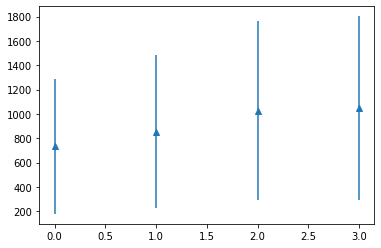

In [137]:
means = [m_f, m_s, m_t, m_q]
ss = [s_f, s_s, s_t, s_q]
x = np.arange(4)

plt.errorbar(x, means, ss, linestyle='None', marker='^')

plt.show()

In [138]:
mat_time = np.zeros((36, 31))
i = 0
for e in td:
    for a in e:
        mat_time[int(a/100),i] += 1
    i += 1
    
    

In [139]:
mat_time /= np.sum(mat_time, axis=0)

mat_time = np.cumsum(mat_time, axis=0)

In [140]:
len(out)

15674

In [141]:
import numpy as np
import matplotlib.pyplot as plt

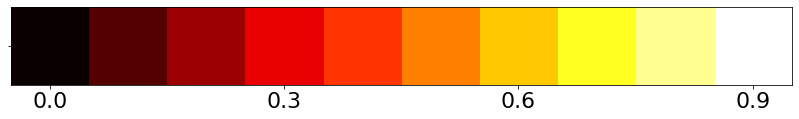

In [142]:
cmap = matplotlib.cm.get_cmap('hot')
plt.figure(figsize=(14,15))
mat = np.arange(0, 1, 0.1)
label = np.array([round(x, 2) for x in mat])
mat = np.expand_dims(mat, axis=0)
plt.imshow(mat, origin="lower", cmap=cmap, interpolation='nearest')

plt.grid(False)
_ = plt.yticks([0], [''])
_ = plt.xticks([0, 3, 6, 9], label[[0, 3, 6, 9]], fontsize=22)
plt.set_cmap(cmap=cmap)

plt.savefig('plots/trip_duration_cmap.jpeg')

In [144]:
mat_time = np.flip(mat_time, axis=0)

In [147]:
plot_mat = mat_time[12:, :]
plot_mat = np.flip(plot_mat, axis=0)

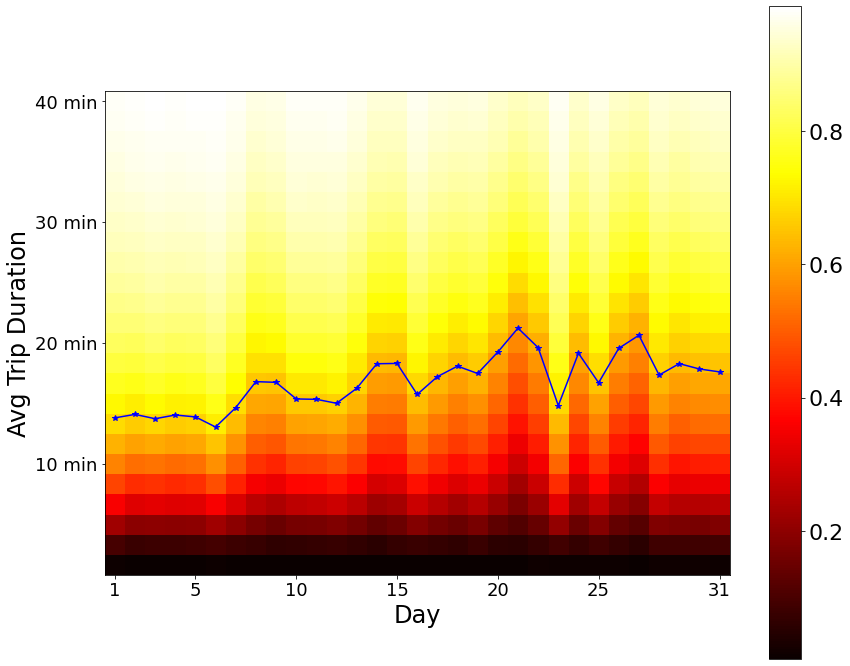

In [148]:

plt.figure(figsize=(14, 12))
plt.imshow(plot_mat, cmap='hot', origin='lower')
plt.grid(False)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.xlabel('Day', fontsize=24)
plt.ylabel('Empirical CDF (1 hour)', fontsize=24)
_ = plt.colorbar().ax.tick_params(labelsize=22)


plt.plot(np.arange(0, 31), np.array(m)/100, color='blue', marker='*')
_ = plt.xticks([0, 4, 9, 14, 19, 24, 30], [1, 5, 10, 15, 20, 25, 31], fontsize=18)
_ = plt.yticks([5, 11, 17, 23], ['10 min', '20 min', '30 min', '40 min'], fontsize=18)
plt.xlabel('Day', fontsize=24)
plt.ylabel('Avg Trip Duration', fontsize=24)
plt.grid(False)
plt.savefig('./plots/cdf_timeduration.eps')




In [149]:
print(nx.algorithms.connectivity.edge_connectivity(g_2_6, s=600, t=40))
print(nx.algorithms.connectivity.edge_connectivity(g_23_27, s=600, t=40))
print("\n")

print(nx.algorithms.connectivity.edge_connectivity(g_2_6, s=600, t=776))
print(nx.algorithms.connectivity.edge_connectivity(g_23_27, s=600, t=776))
print("\n")

print(nx.algorithms.connectivity.edge_connectivity(g_2_6, s=40, t=776))
print(nx.algorithms.connectivity.edge_connectivity(g_23_27, s=40, t=776))
print("\n")

print(nx.algorithms.connectivity.edge_connectivity(g_2_6, s=40, t=524))
print(nx.algorithms.connectivity.edge_connectivity(g_23_27, s=40, t=524))
print("\n")

print(nx.algorithms.connectivity.edge_connectivity(g_2_6, s=600, t=524))
print(nx.algorithms.connectivity.edge_connectivity(g_23_27, s=600, t=524))
print("\n")

print(nx.algorithms.connectivity.edge_connectivity(g_2_6, s=776, t=524))
print(nx.algorithms.connectivity.edge_connectivity(g_23_27, s=776, t=524))
print("\n")

15
18


8
12


8
12


48
13


15
13


8
12




# Different Ratio Graphs # 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
f_4[f_4 == 0] = 1

In [ ]:
r_4 = f_4 / f_4
r_8 = f_8 / f_4
r_11 = f_11 / f_4
r_15 = f_15 / f_4
r_18 = f_18 / f_4
r_22 = f_22 / f_4
r_24 = f_24 / f_4
r_29 = f_29 / f_4

In [ ]:
print(np.max(r_4))
print(np.max(r_8))
print(np.max(r_11))
print(np.max(r_15))
print(np.max(r_18))
print(np.max(r_22))
print(np.max(r_24))
print(np.max(r_29))

In [ ]:
print(np.max(f_4))
print(np.max(f_11))
print(np.max(f_18))
print(np.max(f_24))

print(np.min(f_4))
print(np.min(f_11))
print(np.min(f_18))
print(np.min(f_24))

In [ ]:
cmap = plt.cm.get_cmap('jet')

In [ ]:
mat

In [ ]:
mat.shape

In [ ]:
plt.figure(figsize=(14, 10))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_4, locations, node_size=40, node_color=f_4, cmap=cmap, vmin=0, vmax=1197)
nx.draw_networkx_edges(g_4, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
"""plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_8, locations, node_size=40, node_color=r_8, cmap=cmap, vmin=0, vmax=1.5)
nx.draw_networkx_edges(g_8, locations, alpha=0.8, width=0.2, edge_color='black')"""

mat = np.arange(0,1197, 100)
mat = np.expand_dims(mat, axis=1)
plt.imshow(mat, origin="lower", cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.xticks([0], [''])
_ = plt.yticks([0, 3, 6, 9, 11], mat[[0,3, 6, 9, 11],0])
plt.set_cmap(cmap=cmap)

_ = plt.savefig('./plots/day_4_abs.jpeg')

In [ ]:
plt.figure(figsize=(14, 10))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_11, locations, node_size=40, node_color=f_11, cmap=cmap, vmin=0, vmax=1197)
nx.draw_networkx_edges(g_11, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
"""plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_15, locations, node_size=40, node_color=r_15, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_15, locations, alpha=0.8, width=0.2, edge_color='black')"""

mat = np.arange(0,1197, 100)
mat = np.expand_dims(mat, axis=1)
plt.imshow(mat, origin="lower", cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.xticks([0], [''])
_ = plt.yticks([0, 3, 6, 9, 11], mat[[0,3, 6, 9, 11],0])
plt.set_cmap(cmap=cmap)
_ = plt.savefig('./plots/day_11_abs.jpeg')

In [ ]:
plt.figure(figsize=(14, 10))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_18, locations, node_size=40, node_color=f_18, cmap=cmap, vmin=0, vmax=1197)
nx.draw_networkx_edges(g_18, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
"""plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_22, locations, node_size=40, node_color=r_22, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_22, locations, alpha=0.8, width=0.2, edge_color='black')"""

mat = np.arange(0,1.5, 0.1)
mat = np.expand_dims(mat, axis=1)
plt.imshow(mat, origin="lower", cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.xticks([0], [''])
_ = plt.yticks([0, 3, 6, 9, 12], [0,0.3,0.6,0.9,1.2])
plt.set_cmap(cmap=cmap)


_ = plt.savefig('./plots/day_18_abs.jpeg')

#mplleaflet.show()

In [ ]:
plt.figure(figsize=(14, 10))

plt.subplot(1,2,1)
plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_24, locations, node_size=40, node_color=f_24, cmap=cmap, vmin=0, vmax=1197)
nx.draw_networkx_edges(g_24, locations, alpha=0.8, width=0.2, edge_color='black')

plt.subplot(1,2,2)
"""plt.grid(False)
plt.axis('off')
nx.draw_networkx_nodes(g_29, locations, node_size=40, node_color=r_29, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_29, locations, alpha=0.8, width=0.2, edge_color='black')"""

mat = np.arange(0,1.5, 0.1)
mat = np.expand_dims(mat, axis=1)
plt.imshow(mat, origin="lower", cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.xticks([0], [''])
_ = plt.yticks([0, 3, 6, 9, 12], [0,0.3,0.6,0.9,1.2])
plt.set_cmap(cmap=cmap)

_ = plt.savefig('./plots/day_24_abs.jpeg')

# mplleaflet.show()

In [ ]:
l = [len(e) for k,e in hour_rides(d[3], d[4], df).items()]

In [ ]:
# Important nodes first week
s = set(np.argsort(f_2_6)[-200:])
g_top_2_6 = g_2_6.copy()
rem = [e for e in g_top_2_6.nodes() if e not in s ]

for e in rem:
    g_top_2_6.remove_node(e)

In [ ]:
plt.figure(figsize=(12,8))
plt.grid(False)
nx.draw_networkx_nodes(g_top_2_6, locations, node_size=40, node_color='black')
nx.draw_networkx_edges(g_top_2_6, locations, alpha=0.8, width=0.2, edge_color='gray')
plt.axis(False)

mplleaflet.show()

In [ ]:
# Important nodes last week
s = set(np.argsort(f_23_27)[-200:])
g_top_23_27 = g_23_27.copy()
rem = [e for e in g_top_23_27.nodes() if e not in s ]

for e in rem:
    g_top_23_27.remove_node(e)

In [ ]:
plt.figure(figsize=(12,8))
plt.grid(False)
nx.draw_networkx_nodes(g_top_23_27, locations, node_size=40, node_color='black')
nx.draw_networkx_edges(g_top_23_27, locations, alpha=0.8, width=0.2, edge_color='gray')
plt.axis(False)

mplleaflet.show()

# Heat Diffusion #

In [ ]:
from pygsp.filters import Heat

In [ ]:
# good nodes , 40, 600, 776

In [ ]:
source_nodes = [524]

In [ ]:
t = np.arange(0, 100)

h = Heat(G_2_6, tau=t)

source = np.zeros(G_2_6.U.shape[0])
source[transform_source(source_nodes, isolated_nodes_2_6)] = 100

y_2_6 = h.filter(source)


In [ ]:
for e in sorted(isolated_nodes_2_6):
    y_2_6 = np.insert(y_2_6, e, 0, axis=0)

In [ ]:
t = np.arange(0, 100)

h = Heat(G_23_27, tau=t)

source = np.zeros(G_23_27.U.shape[0])
source[transform_source(source_nodes, isolated_nodes_23_27)] = 100

y_23_27 = h.filter(source)

In [ ]:
for e in sorted(isolated_nodes_23_27):
    y_23_27 = np.insert(y_23_27, e, 0, axis=0)

In [ ]:
hotmap = plt.cm.get_cmap('viridis')

In [ ]:
node_size_2 = np.ones(g_2_6_tot.number_of_nodes()) * 40
node_size_2[source_nodes[0]] = 60
node_size_23 = np.ones(g_23_27_tot.number_of_nodes()) * 40
node_size_23[source_nodes[0]] = 60

In [ ]:
node_size_2.shape

In [ ]:
time = 99
node = source_nodes[0]

In [ ]:
vec_2_6 = y_2_6[:,time].copy()
vec_2_6[vec_2_6 > 1] = 1
colors_2_6 = [matplotlib.colors.to_hex(e, keep_alpha=False) for e in hotmap(vec_2_6)]

vec_2_6_6 = y_2_6[:,9].copy()
vec_2_6_6[vec_2_6_6 > 1] = 1
colors_2_6_6 = [matplotlib.colors.to_hex(e, keep_alpha=False) for e in hotmap(vec_2_6_6)]

vec_23_27 = y_23_27[:, time].copy()
vec_23_27[vec_23_27 > 1] = 1
colors_23_27 = [matplotlib.colors.to_hex(e, keep_alpha=False) for e in hotmap(vec_23_27)]

vec_23_27_6 = y_23_27[:,9].copy()
vec_23_27_6[vec_23_27_6 > 1] = 1
colors_23_27_6 = [matplotlib.colors.to_hex(e, keep_alpha=False) for e in hotmap(vec_23_27_6)]

colors_2_6[source_nodes[0]] = matplotlib.colors.to_hex('red', keep_alpha=False)
colors_23_27[source_nodes[0]] = matplotlib.colors.to_hex('red', keep_alpha=False)


In [ ]:
draw_nodes_2 = [x for x in g_2_6_tot.nodes() if x not in out_nodes]
draw_edges_2 = [x for x in g_2_6_tot.edges() if x[0] not in out_nodes and x[1] not in out_nodes]

draw_nodes_23 = [x for x in g_23_27_tot.nodes() if x not in out_nodes]
draw_edges_23 = [x for x in g_23_27_tot.edges() if x[0] not in out_nodes and x[1] not in out_nodes]



In [ ]:
for x in reversed(list(out_nodes)):
    node_size_2 = np.delete(node_size_2, x)
    colors_2_6 = np.delete(colors_2_6, x)

In [ ]:
for x in reversed(list(out_nodes)):
    node_size_23 = np.delete(node_size_23, x)
    colors_23_27 = np.delete(colors_23_27, x)

In [ ]:
plt.figure(figsize=(14,15))
mat = np.arange(0, 1, 0.1)
label = np.array([round(x, 2) for x in mat])
mat = np.expand_dims(mat, axis=0)
plt.imshow(mat, origin="lower", cmap=cmap, interpolation='nearest')

plt.grid(False)
_ = plt.yticks([0], [''])
_ = plt.xticks([0, 3, 6, 9], label[[0, 3, 6, 9]], fontsize=22)
plt.set_cmap(cmap=hotmap)

plt.savefig('plots/heat_cmap.jpg')

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)

plt.title('First Week', fontsize=22)
plt.grid(False)
plt.axis(False)
nx.draw_networkx_nodes(g_2_6_tot, locations, nodelist=draw_nodes_2,  node_size=node_size_2, node_color=colors_2_6, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_2_6_tot, locations, edgelist=draw_edges_2, alpha=0.8, width=0.2, edge_color='black')


plt.subplot(1,2,2)
plt.title('Fourth Week', fontsize=22)
plt.grid(False)
plt.axis(False)
nx.draw_networkx_nodes(g_23_27_tot, locations, nodelist=draw_nodes_23, node_size=node_size_23, node_color=colors_23_27, cmap=cmap, vmin=0, vmax=1)
nx.draw_networkx_edges(g_23_27_tot, locations, edgelist=draw_edges_23, alpha=0.8, width=0.2, edge_color='black')

# plt.savefig('plots/heat_{}.jpeg'.format(source_nodes[0]))

In [ ]:
plt.figure(figsize=(18,8))

# plt.plot(y_2_6[:,0], color='blue', alpha=1)
# plt.plot(y_2_6[:,3], color='green', alpha=1)
# plt.plot(y_2_6[:,6], color='gray')
plt.plot(y_2_6[:,9], color='blue')

# plt.plot(y_2_6[:,0], color='blue', alpha=1)
# plt.plot(y_23_27[:,3], color='green', alpha=1)
# plt.plot(y_23_27[:,6], color='gray')
plt.plot(y_23_27[:,9], color='green', alpha=0.5)
_ = plt.ylim(0, 1)

_= plt.legend(['First Week', 'Last Week'], fontsize=22)

In [ ]:
# Look at the diffusions

plt.plot()

In [ ]:
two_order_ns = set()
n = source_nodes[0]
two_order_ns.add(n)
for e in nx.neighbors(g_2_6_tot, n):
    two_order_ns.add(e)
new_nodes = set()
for e in two_order_ns:
    for n in nx.neighbors(g_2_6_tot, e):
        new_nodes.add(n)
        
two_order_ns = two_order_ns.union(new_nodes)
    
g = nx.subgraph(g_2_6, list(two_order_ns))

In [ ]:
df[df['start station id'] == 3776]

In [ ]:
np.sum(nx.adj_matrix(g_2_6_tot)[source_nodes[0],:].todense())

In [ ]:
np.sum(nx.adj_matrix(g_23_27_tot)[source_nodes[0],:].todense())

In [ ]:
two_order_ns = set()
n = source_nodes[0]
two_order_ns.add(n)
for e in nx.neighbors(g_23_27_tot, n):
    two_order_ns.add(e)
new_nodes = set()
for e in two_order_ns:
    for n in nx.neighbors(g_23_27_tot, e):
        new_nodes.add(n)
        
two_order_ns = two_order_ns.union(new_nodes)
    
g = nx.subgraph(g_23_27, list(two_order_ns))

In [ ]:
cols=[]
for e in g.nodes:
    if e==source_nodes[0]:
        cols.append('red')
    else:
        cols.append('black')

In [ ]:
plt.subplot(1,2,1)
plt.grid(False)
nx.draw_networkx_nodes(g, locations, node_size=65, node_color=cols)
nx.draw_networkx_edges(g, locations, alpha=0.8, width=0.2, edge_color='black')
plt.axis(False)

mplleaflet.show()

In [ ]:
3398

In [ ]:
df[df['start station id'] == 3398]

In [ ]:
plt.figure(figsize=(12,10))
mat = np.arange(0, 1, 0.075)
mat = np.expand_dims(mat, 0)
plt.imshow(mat, cmap=hotmap, interpolation='nearest')
plt.grid(False)
_ = plt.yticks([0], [''])
_ = plt.xticks([0, 4, 8, 12], [0,0.3,0.6,0.9], fontsize=18)
plt.savefig('plots/heat_cmap.eps')

In [ ]:
index_23 = dict(zip(g_23_27.nodes(), np.arange(g_23_27.number_of_nodes())))
cols_bridge = np.zeros(g_23_27.number_of_nodes())

In [ ]:
upper_man_idx = list(upper_man_idx)
queens_idx = list(queens_idx)

In [ ]:
# Illegal Bridges
for e in upper_man_idx[:100]:
    cols_bridge[index_23[e]] = 1

In [ ]:
plt.figure(figsize=(8, 12))

plt.grid(False)
nx.draw_networkx_nodes(g_23_27, locations, node_size=40, node_color=cols_bridge)
nx.draw_networkx_edges(g_23_27, locations, alpha=0.8, width=0.2, edge_color='black')
plt.axis(False)

In [ ]:
index_2_6 = dict(zip(g_2_6.nodes(), np.arange(g_2_6.number_of_nodes())))


In [ ]:
zoom = []
for k, v in locations.items():
    if v[0] > -73.96 and v[0] < -73.90 and v[1] > 40.77 and v[1] < 40.80:
        zoom.append(k)
zoom = np.array(zoom)

In [ ]:
"""
 v[0] > -73.96 and v[0] < -73.90 and v[1] > 40.76 and v[1] < 40.80
manhattan = list(np.arange(55))
manhattan.extend([60, 69, 96, 99])
queens = list(set(np.arange(102)).difference(set(manhattan)))"""

In [ ]:
manhattan = list(np.arange(20))
# manhattan.extend([60, 69, 96, 99])
queens = list(set(np.arange(40)).difference(set(manhattan)))

In [ ]:
len(zoom)

In [ ]:
cols_bridge = ['blue' for e in np.arange(g_2_6.number_of_nodes())]

for e in zoom[manhattan]:
    if index_2_6.get(e) is not None:
        cols_bridge[index_2_6[e]] = 'yellow'

for e in zoom[queens]:
    if index_2_6.get(e) is not None:
        cols_bridge[index_2_6[e]] = 'red'
        
plt.figure(figsize=(8, 12))

plt.grid(False)
nx.draw_networkx_nodes(g_2_6, locations, node_size=40, node_color=cols_bridge, cmap=colors_bridge)
nx.draw_networkx_edges(g_2_6, locations, alpha=0.8, width=0.2, edge_color='black')
plt.axis(False) 

# mplleaflet.show()

In [ ]:
# first_week

# start station id --> 3 
# end station id --> 7
set_manhattan = set(zoom[manhattan])
set_queens = set(zoom[queens])

start_row = d[2] 
end_row = d[7]

first_cross = []

for row in df.iloc[start_row:end_row].iterrows():
    if id_index[row[1][3]] in set_manhattan and id_index[row[1][7]] in set_queens:
        first_cross.append(row[0])
    elif id_index[row[1][7]] in set_manhattan and id_index[row[1][3]] in set_queens:
        first_cross.append(row[0])
    

In [ ]:
# last

# start station id --> 3 
# end station id --> 7
set_manhattan = set(zoom[manhattan])
set_queens = set(zoom[queens])

start_row = d[23] 
end_row = d[28]

last_cross = []

for row in df.iloc[start_row:end_row].iterrows():
    if id_index[row[1][3]] in set_manhattan and id_index[row[1][7]] in set_queens:
        last_cross.append(row[0])
    elif id_index[row[1][7]] in set_manhattan and id_index[row[1][3]] in set_queens:
        last_cross.append(row[0])
    

In [ ]:
df.iloc[first_cross]['tripduration'].describe()


In [ ]:
f = np.array(df.iloc[first_cross]['tripduration'])
f = f[f<2400]

In [ ]:
l = np.array(df.iloc[last_cross]['tripduration'])
l = l[l<2400]

In [ ]:
_ = plt.hist(f, color='blue')
plt.grid(False)

In [ ]:
_ = plt.hist(l, color='blue')
plt.grid(False)

In [ ]:
df.iloc[last_cross]['start station id']

# Metro Data #

In [ ]:
# import shapefile as shp
import seaborn as sns
from pyproj import Proj, transform

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from shapely.geometry import shape, Point

import shapefile

from utils.shapefile import read_shapefile, plot_shape, plot_map, plot_map_fill

In [ ]:
# UTILS

def find_day_metro(day, month, df):
    day = str_int(day)
    month = str_int(month)
    ids = []
    for index, row in df.iterrows():
        if row['date'].split('-')[-1] == day and row['date'].split('-')[-2] == month:
            ids.append(index)
    return ids
        
def str_int(i):
    if i < 10:
        return '0' + str(i)
    else:
        return str(i)

def calc_color(data, num_bins=None, ref_bins=None, name='YlOrBr'):
    
    cmap=plt.get_cmap(name)
    
    if ref_bins is None:
        new_data, bins = pd.qcut(data, num_bins, retbins=True, labels=list(range(num_bins)))
    else:
        bins = ref_bins
        num_bins = len(ref_bins)-1
        new_data = pd.cut(data, ref_bins, include_lowest=True, labels=list(range(num_bins)))
    m = num_bins - 1
    color_ton = []
    for val in new_data:
        color_ton.append(matplotlib.colors.to_hex(cmap(val/m), keep_alpha=False)) 
    
    #plot color map
    
    """cat = np.arange(num_bins)
    ex = cat / (num_bins-1)
    ex = np.expand_dims(ex, 1)
    
    plt.imshow(ex, cmap=cmap)
    plt.grid(False)
    plt.yticks([0], [''])
    _ = plt.axis('on')"""

    return color_ton, bins

In [ ]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(12,8))

%matplotlib inline

sf = shapefile.Reader("./data/shapefiles_/ZIP_CODE_040114.dbf")

df_shape = read_shapefile(sf)

In [ ]:
metro_data = pd.read_csv('./data/metro/metro_whole_station.csv')

In [ ]:
metro_data.head()

In [ ]:
# Find Geo-Coordinates for stations

stat_geo = {}
for index, row in metro_data.iterrows():
    coor = np.array([row['gtfs_longitude'], row['gtfs_latitude']])
    stat_geo[row['stop_name']] = coor
    
# Find xlim and ylim 
x_lim = [100, -100]
y_lim = [100, 0]
for k,v in locations.items():
    
    if v[0] < x_lim[0]:
        x_lim[0] = v[0]
    elif v[0] > x_lim[1]:
        x_lim[1] = v[0]
        
    if v[1] < y_lim[0]:
        y_lim[0] = v[1]
    elif v[1] > y_lim[1]:
        y_lim[1] = v[1]
        
        


In [ ]:
# Find Zip Code for Stations

points = [(k, Point(v)) for k,v in stat_geo.items()]
multis = [(e.record[0], shape(e.shape.__geo_interface__)) for e in sf.shapeRecords()]

stat_zip = {}

for stat, pt in points:
    point = shape(pt)
    for zip_code, poly in multis:
        if point.within(poly): 
            stat_zip[stat] = zip_code

In [ ]:
# Find Zip Code for BS - Stations

points_bs = [(k, Point(v)) for k,v in locations.items()]
multis_bs = [(e.record[0], shape(e.shape.__geo_interface__)) for e in sf.shapeRecords()]

bs_zip = {}
not_found = []
for stat, pt in points_bs:
    point = shape(pt)
    for zip_code, poly in multis_bs:
        if point.within(poly): 
            bs_zip[stat] = zip_code
    if bs_zip.get(stat) is None:
        not_found.append(stat)
        
# Find f_2_6_tot with all nodes 

f_24_tot = list(np.sum(adj_24_tot, axis=0))


In [ ]:
"""for n in reversed(not_found):
    del f_2_6_tot[n]"""

f_24_tot = np.array(f_24_tot)



In [ ]:
zip_index = dict(zip(df_shape['ZIPCODE'], np.arange(len(df_shape))))

In [ ]:
import pickle 

In [ ]:
# Create indexes for March 

"""march_ids = []
for d in range(1, 32):
    march_ids.append(find_day_metro(d, 3, metro_data))

with open('./data/python_variables/march_ids.pickle', 'wb') as file:
    pickle.dump(march_ids, file)
"""

In [ ]:
with open('./data/python_variables/march_ids.pickle', 'rb') as file:
    march_ids = pickle.load(file)

In [ ]:
# Find Daily runs

days = [4, 11, 18, 24]

days_metro = dict()

for day in days:
    days_metro[day] = {}
    for index, row in metro_data.iloc[march_ids[day-1]].iterrows():
        zip_code = stat_zip.get(row['stop_name'])
        if zip_code is not None:
            if days_metro[day].get(zip_code) is None:
                days_metro[day][zip_code] = row['entries'] 
            else:
                days_metro[day][zip_code] += row['entries'] 
    print("Aggregated day {}".format(day))

# Collect By indexes

idxs = {}
for day in days:
    idxs[day] = []
    idxs[day].append(np.array([zip_index[str(e)] for e in days_metro[day].keys() ]))
    idxs[day].append(np.array(list(days_metro[day].values())))
    idxs[day].append(idxs[day][1] / idxs[4][1])

In [ ]:
for k, v in idxs.items():
    v[1] = np.where(v[1] > 150000, 150000, v[1])

In [ ]:
ref, bins = pd.qcut(idxs[4][1], 12, retbins=True, labels=list(range(12)))

In [ ]:
bins

In [ ]:
bin_lab = np.array([int(e) for e in bins])

In [ ]:
bin_lab = np.insert(bin_lab, 0, 0)

In [ ]:
# For relative

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
cmap = plt.get_cmap('jet')
plt.figure(figsize=(12,10))
mat = bins.copy()
mat = np.expand_dims(mat, 0)
plt.imshow(mat, cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.yticks([0], [''])
_ = plt.xticks([0, 2, 5, 8, 10], (mat[0,[0, 2, 5, 8, 10]]), fontsize=18)
# plt.savefig('plots/metro_relative_cmap.eps')

In [ ]:
cmap = plt.get_cmap('jet')
plt.figure(figsize=(12,10))
mat = bin_lab.copy()
mat = np.expand_dims(mat, 0)
plt.imshow(mat, cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.yticks([0], [''])
_ = plt.xticks([0, 3, 6, 9, 13 ], (mat[0,[0, 3, 6, 9, 13 ]]), fontsize=18)
plt.savefig('plots/metro_relative_cmap.eps')

In [ ]:
for k, v in idxs.items():

    color_ton, _ = calc_color(v[2], ref_bins=bins, name='jet')

    ax = plot_map_fill(v[0], sf, color_ton, x_lim=x_lim, y_lim=y_lim, figsize=(8,6))
    
    _ = plt.xlabel("Longitude", fontsize=22)
    _ = plt.ylabel("Latidute", fontsize=22)
    
    _ = plt.savefig('plots/metro{}.eps'.format(k))
    

In [ ]:
len(f_24_tot)

In [ ]:
len(bs_zip)

In [ ]:
# Find BS runs
bs_agg = dict()

for k, v in enumerate(f_24):
    zip_code = bs_zip.get(k)
    if zip_code is not None:
        if bs_agg.get(zip_code) is None:
            bs_agg[zip_code] = v
        else:
            bs_agg[zip_code] += v 
print("Aggregated week one")

# Collect By indexes

bs_tot = []

bs_tot.append(np.array([zip_index[str(e)] for e in bs_agg.keys() ]))
bs_tot.append(np.array(list(bs_agg.values())))


In [ ]:
# Plot BS Aggregated per ZIP CODE

# bs_tot[1] = np.where(bs_tot[1] > 6000, 6000, bs_tot[1] )

ref, bins = pd.qcut(bs_tot[1], 12, retbins=True, labels=list(range(12)))
bin_lab = np.array([int(e) for e in bins])

cmap = plt.get_cmap('jet')
plt.figure(figsize=(12,10))
mat = bins.copy()
mat = np.expand_dims(mat, 0)
plt.imshow(mat, cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.yticks([0], [''])
_ = plt.xticks([0, 3, 6, 9, 12], (bin_lab[[0, 3, 6, 9, 12]]), fontsize=18)

plt.savefig('plots/zip_bs_cmap_4.eps')

In [ ]:


# bs_tot[1] = np.where(bs_tot[1] > 2000, 2000, bs_tot[1])

color_ton, _ = calc_color(bs_tot[1], ref_bins=bins, name='jet')

ax = plot_map_fill(bs_tot[0], sf, color_ton, x_lim=x_lim, y_lim=y_lim, figsize=(8,6))

_ = plt.xlabel("Longitude", fontsize=22)
_ = plt.ylabel("Latidute", fontsize=22)

_ = plt.savefig('plots/bs_zip_24.eps')

In [ ]:
# Left

zip_left = pd.read_csv('./data/zip_left.csv', names=['zipcode', 'perc'], header=None)
    


In [ ]:
zip_left.head()

In [ ]:
idx_left = [zip_index[str(e)] for e in zip_left['zipcode']]

In [ ]:
bins = [0, 1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8]

In [ ]:
color_ton, _ = calc_color(list(zip_left['perc']), ref_bins=bins)

ax = plot_map_fill(idx_left, sf, color_ton, x_lim=x_lim, y_lim=y_lim, figsize=(8,6))

In [ ]:
"""import geopandas as gpd

tmp = gpd.GeoDataFrame.from_file('./data/shapefiles/ZIP_CODE_040114.shp')

tmpWGS84 = tmp.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

tmpWGS84.to_file('./data/shapefiles_/ZIP_CODE_040114.shp')"""

# Covid cases 

In [ ]:
df_covid = pd.read_csv('data/coronavirus-data/data-by-modzcta.csv')

In [ ]:
df_covid.head()

In [ ]:
covid_zip = {}

set_zip = set(zip_index.keys())


In [ ]:
for k, row in df_covid.iterrows():
    if str(row['MODIFIED_ZCTA']) in set_zip:
        covid_zip[zip_index[str(row['MODIFIED_ZCTA'])]] = row['COVID_CASE_COUNT']

In [ ]:
df_covid['COVID_CASE_COUNT'].describe()

In [ ]:
plt.plot(list(covid_zip.values()))

In [ ]:
color_covid, bins_covid = calc_color(list(covid_zip.values()), num_bins=14, name='jet')
ax = plot_map_fill(list(covid_zip.keys()), sf, color_covid, x_lim=[-74.05, -73.90], y_lim=[40.6, 40.80], figsize=(8,6))

# plt.savefig('plots/covid_cases.eps')

In [ ]:
cmap = plt.get_cmap('jet')
plt.figure(figsize=(12,10))
bins_covid_int = [int(x) for x in bins_covid]
mat = bins_covid_int.copy()
mat = np.expand_dims(mat, 0)
plt.imshow(mat, cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.yticks([0], [''])
_ = plt.xticks([0, 3, 6, 9, 12], (mat[0, [0, 3, 6, 9, 12]]), fontsize=18)

plt.savefig('plots/covid_cmap.eps')

# Analsys of new network 

In [ ]:
ratio_adj = adj_23_27_tot / (adj_2_6_tot+1)

In [ ]:
ratio_adj[ratio_adj < 1] = 0

for i in range(ratio_adj.shape[0]):
    ratio_adj[i,i] = 0

In [ ]:
np.sum(ratio_adj)

In [ ]:
# Find connections that has grown more than 5 times with at least 20 runs 
idx = np.argwhere(np.logical_and(ratio_adj >= 2, adj_23_27_tot >=  10))
idx_remove = np.argwhere(np.logical_or(ratio_adj < 2, adj_23_27_tot < 10))

In [ ]:
for e in idx_remove:
    ratio_adj[e[0], e[1]] = 0


In [ ]:

g_ratio = nx.from_numpy_matrix(ratio_adj)

In [ ]:
isolated_nodes_ratio = []
for e in nx.connected_components(g_ratio):
    if len(e) == 1:
        isolated_nodes_ratio.append(e.pop())

g_ratio.remove_nodes_from(isolated_nodes_ratio)

In [ ]:
plt.figure(figsize=(10, 12))

nx.draw_networkx_nodes(g_ratio, locations, node_size=40, node_color='black')
nx.draw_networkx_edges(g_ratio, locations, alpha=0.8, width=0.9, edge_color='black')
plt.axis(False)
plt.grid(False)

mplleaflet.show()

## Decreasing

In [ ]:
ratio_adj_dec = adj_23_27_tot / (adj_2_6_tot+1)

In [ ]:
ratio_adj_dec[ratio_adj_dec > 1] = 0

for i in range(ratio_adj_dec.shape[0]):
    ratio_adj_dec[i,i] = 0

In [ ]:
# Find connections that has grown more than 5 times with at least 20 runs 
idx = np.argwhere(np.logical_and(ratio_adj_dec <= 0.5, adj_23_27_tot >=  10))
idx_remove = np.argwhere(np.logical_or(ratio_adj_dec > 0.5, adj_23_27_tot < 10))

In [ ]:
idx.shape

In [ ]:
for e in idx_remove:
    ratio_adj_dec[e[0], e[1]] = 0

In [ ]:
g_dec = nx.from_numpy_matrix(ratio_adj_dec)

In [ ]:
isolated_nodes_ratio_dec = []
for e in nx.connected_components(g_dec):
    if len(e) == 1:
        isolated_nodes_ratio_dec.append(e.pop())

g_dec.remove_nodes_from(isolated_nodes_ratio_dec)

In [ ]:
plt.figure(figsize=(10, 12))

nx.draw_networkx_nodes(g_ratio, locations, node_size=20, node_color='black')
nx.draw_networkx_edges(g_ratio, locations, alpha=0.8, width=0.9, edge_color='black')
plt.axis(False)
plt.grid(False)


nx.draw_networkx_nodes(g_dec, locations, node_size=20, node_color='black')
nx.draw_networkx_edges(g_dec, locations, alpha=0.8, width=0.9, edge_color='red')
plt.axis(False)
plt.grid(False)

mplleaflet.show()

In [ ]:
G_2_6.e

In [ ]:
plt.figure(figsize=(14, 10))
plt.plot(G_2_6.e, color='blue', linewidth=2)
_ = plt.plot(G_9_13.e, color='gray', linewidth=2)
_ = plt.plot(G_16_20.e, color='red', linewidth=2)
_ = plt.plot(G_23_27.e, color='green', linewidth=2)


plt.grid(True)
_ = plt.xticks(fontsize=22)
_ = plt.yticks(fontsize=22)
_ = plt.xlabel("Eigenvalue Index", fontsize=26)

plt.legend(['First', 'Second', 'Third', 'Last'], fontsize=22)

plt.savefig('plots/eigens_tot.eps')

In [ ]:
plt.figure(figsize=(14,10))
plt.plot(G_2_6.e[:5], color='blue', linewidth=2)
_ = plt.plot(G_9_13.e[:5], color='gray', linewidth=2)
_ = plt.plot(G_16_20.e[:5], color='red', linewidth=2)
_ = plt.plot(G_23_27.e[:5], color='green', linewidth=2)

plt.grid(True)
_ = plt.xticks(fontsize=22)
_ = plt.yticks(fontsize=22)
_ = plt.xlabel("Eigenvalue Index", fontsize=26)

plt.legend(['First', 'Second', 'Third', 'Last'], fontsize=22)
# plt.savefig('plots/eigens_100.eps')

In [ ]:
G_2_6.e[:2]

In [ ]:
G_23_27.e[:2]

In [ ]:
len(g_9_13)

In [ ]:
len(g_16_20)

In [ ]:
len(g_23_27)

# Population

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_html('data/view-source_https___www.newyork-demographics.com_zip_codes_by_population.html')[0]

In [ ]:
import re

In [ ]:
# start at 70 
re.split('>|<','<a href=\"11385-demographics">11385</a>')

In [ ]:
pop_zip = {}
i = 5
for k,v in data.iloc[70:].iterrows():
    i += 1
    if type(v[1]) is str and "-demographics\">" in v[1]:
        zip_code = re.split('>|<',v[1])[2]
        i = 0
    elif i == 3:
        pop_zip[zip_code] = int(v[1])
    

In [ ]:
pop_zip_id = {}
for k, v in pop_zip.items():
    if k in set_zip:
        pop_zip_id[zip_index[k]] = pop_zip[k]

In [ ]:
color_covid, bins_pop = calc_color(list(pop_zip_id.values()), num_bins=12, name='jet')
ax = plot_map_fill(list(pop_zip_id.keys()), sf, color_covid, x_lim=x_lim, y_lim=y_lim, figsize=(8,6))

plt.savefig('plots/covid_cases.eps')

In [ ]:
cmap = plt.get_cmap('jet')
plt.figure(figsize=(12,10))
bins_int = [int(x) for x in bins_pop]
mat = bins_int.copy()
mat = np.expand_dims(mat, 0)
plt.imshow(mat, cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.yticks([0], [''])
_ = plt.xticks([0, 3, 6, 9, 12], (mat[0, [0, 3, 6, 9, 12]]), fontsize=18)


In [ ]:
len(covid_zip)

In [ ]:
len(pop_zip_id)

In [ ]:
perc_zip ={}
for k, v in covid_zip.items():
    perc_zip[k] = v / int(pop_zip_id[k] / 1000 )

In [ ]:
color_covid, bins = calc_color(list(perc_zip.values()), num_bins=12, name='jet')
ax = plot_map_fill(list(perc_zip.keys()), sf, color_covid, x_lim=x_lim, y_lim=y_lim, figsize=(8,6))
plt.xlabel("Longitude", fontsize=22)
plt.ylabel("Latitude",  fontsize=22)

plt.savefig('plots/covid_perc.eps')

In [ ]:
cmap = plt.get_cmap('jet')
plt.figure(figsize=(12,10))
bins_int = [int(x) for x in bins]
mat = bins_int.copy()
mat = np.expand_dims(mat, 0)
plt.imshow(mat, cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.yticks([0], [''])
_ = plt.xticks([0, 3, 6, 9, 12], (mat[0, [0, 3, 6, 9, 12]]), fontsize=18)

plt.savefig('plots/cmap_covid_perc.eps')

In [ ]:
df_covid

In [ ]:
death_zip = {}
for k, row in df_covid.iterrows():
    if str(row['MODIFIED_ZCTA']) in set_zip:
        death_zip[zip_index[str(row['MODIFIED_ZCTA'])]] = row['COVID_DEATH_COUNT']

In [ ]:
death_perc_zip ={}
for k, v in death_zip.items():
    perc_zip[k] = v / int(pop_zip_id[k] / 1000 )

In [ ]:
bins = [0, 1, 2, 3, 4, 5, 6]

In [ ]:
color_covid, bins = calc_color(list(perc_zip.values()), ref_bins=bins, name='jet')
ax = plot_map_fill(list(perc_zip.keys()), sf, color_covid, x_lim=[-74.05, -73.8], y_lim=[40.6, 40.9], figsize=(8,6))

plt.savefig('plots/covid_death_perc.eps')

In [ ]:
cmap = plt.get_cmap('jet')
plt.figure(figsize=(12,10))
bins_int = [int(x) for x in bins]
mat = bins_int.copy()
mat = np.expand_dims(mat, 0)
plt.imshow(mat, cmap=cmap, interpolation='nearest')
plt.grid(False)
_ = plt.yticks([0], [''])
_ = plt.xticks([0, 2, 4, 5], (mat[0, [0, 2, 4, 5]]), fontsize=18)

plt.savefig('plots/cmap_death_perc.eps')

# April #

In [ ]:
df_4 = pd.read_csv('./data/202004-citibike-tripdata.csv')
n_start_station = len(df_4['start station id'].unique())
n_end_station = len(df_4['end station id'].unique())


total_station_id = set(df_4['start station id']).union(set(df_4['end station id']))
n_tot_station = len(total_station_id)

id_index_4 = dict(zip(sorted(total_station_id), np.arange(n_tot_station)))

In [ ]:
locations_4 = dict()
for e in id_index_4.keys():
    if df_4[df_4['start station id'] == e]['start station latitude'].shape[0]:
        locations_4[id_index_4[e]] = (df_4[df_4['start station id'] == e]['start station longitude'].iloc[0],
                                  df_4[df_4['start station id'] == e]['start station latitude'].iloc[0])
    else:
        locations_4[id_index_4[e]] = (df_4[df_4['end station id'] == e]['end station longitude'].iloc[0],
                                  df_4[df_4['end station id'] == e]['end station latitude'].iloc[0])
 

In [ ]:
# Dictionary with days starting indexes
"""d_4 = days_index(df_4)
with open('./data/python_variables/april_index.pickle', 'wb') as file:
    pickle.dump(d_4, file)
"""

In [ ]:
# Load day indexes for March
with open('./data/python_variables/april_index.pickle', 'rb') as file:
    d_4 = pickle.load(file)

In [ ]:
d_a = [e for e in d_4.values()]
d_a.append(df_4.shape[0])
d_a = np.array(d_a)
rides_day_4 = d_a[1:] - d_a[:-1]

# Rides Per Day
plt.figure(figsize=(12,8))
_ = plt.plot(np.arange(1, 31), rides_day_4, color='blue', marker='*')
# _ = plt.xticks(np.arange(1, 8), [1, 5, 10, 15, 20, 25, 31], fontsize=18)
_ = plt.xlabel("Day of April", fontsize=24, color='black')
_ = plt.ylabel("Rides per day", fontsize=24, color='black')
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.grid(False)
# plt.savefig('./plots/days_aggregated.eps')

In [ ]:
df_4.head()

In [ ]:
df_4['usertype'].unique()

# May # 

In [ ]:
df_5 = pd.read_csv('./data/202005-citibike-tripdata.csv')
n_start_station = len(df_5['start station id'].unique())
n_end_station = len(df_5['end station id'].unique())


total_station_id = set(df_5['start station id']).union(set(df_5['end station id']))
n_tot_station = len(total_station_id)

id_index_5 = dict(zip(sorted(total_station_id), np.arange(n_tot_station)))

In [ ]:
locations_5 = dict()
for e in id_index_5.keys():
    if df_5[df_5['start station id'] == e]['start station latitude'].shape[0]:
        locations_5[id_index_5[e]] = (df_5[df_5['start station id'] == e]['start station longitude'].iloc[0],
                                  df_5[df_5['start station id'] == e]['start station latitude'].iloc[0])
    else:
        locations_5[id_index_5[e]] = (df_5[df_5['end station id'] == e]['end station longitude'].iloc[0],
                                  df_5[df_5['end station id'] == e]['end station latitude'].iloc[0])
 

In [ ]:
# Dictionary with days starting indexes
"""d_5 = days_index(df_5)
with open('./data/python_variables/may_index.pickle', 'wb') as file:
    pickle.dump(d_5, file)"""


In [ ]:
# Load day indexes for March
with open('./data/python_variables/april_index.pickle', 'rb') as file:
    d_4 = pickle.load(file)

In [ ]:
d_a = [e for e in d_5.values()]
d_a.append(df_5.shape[0])
d_a = np.array(d_a)
rides_day_5 = d_a[1:] - d_a[:-1]

# Rides Per Day
plt.figure(figsize=(12,8))
_ = plt.plot(np.arange(1, 32), rides_day_5, color='blue', marker='*')
# _ = plt.xticks(np.arange(1, 8), [1, 5, 10, 15, 20, 25, 31], fontsize=18)
_ = plt.xlabel("Day of April", fontsize=24, color='black')
_ = plt.ylabel("Rides per day", fontsize=24, color='black')
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
plt.grid(False)
# plt.savefig('./plots/days_aggregated.eps')

In [ ]:
len(rides_day_5)

In [ ]:
df_5.head()

# June # 

In [ ]:
df_6 = pd.read_csv('./data/CitiBike_Covid_Padua.csv')


In [ ]:
a = [ int(e) for e in df_6.logicalTerminal.unique()]

In [ ]:
len(df_6['logicalTerminal'].unique())

In [ ]:
df_6.head()

# Workforce #

In [ ]:
df_wf = pd.read_csv('data/CitiBike_2020_Padua.csv')

In [ ]:
df_wf.head()

In [ ]:
df_wf.iloc[0]['start_time'].split('/')[1][1]

In [ ]:
id_wf = []
for i,e in df_wf.iterrows():
    if e.CW == True:
        id_wf.append(i)